In [3]:
# @matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
# from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for exmaple, change tghe context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind",color_codes=True,
              rc={"figure.figsize":[12, 8]})

# Exploring `faitai`s Tabular Learner

## How to do it

### 1. Import the libraries

In [5]:
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from evaluation_report import performance_evaluation_report
from evaluation_report import performance_evaluation_report_fastai
import pandas as pd

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load the dataset from a CSV file

In [6]:
df = pd.read_csv('./datasets/credit_card_default.csv')

df.head()

,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Paid duly,Paid duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Paid duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Paid duly,Unknown,Paid duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
df.isna().any()

limit_bal                     False
sex                            True
education                      True
marriage                       True
age                            True
payment_status_sep            False
payment_status_aug            False
payment_status_jul            False
payment_status_jun            False
payment_status_may            False
payment_status_apr            False
bill_statement_sep            False
bill_statement_aug            False
bill_statement_jul            False
bill_statement_jun            False
bill_statement_may            False
bill_statement_apr            False
previous_payment_sep          False
previous_payment_aug          False
previous_payment_jul          False
previous_payment_jun          False
previous_payment_may          False
previous_payment_apr          False
default_payment_next_month    False
dtype: bool

### 3. Define the target, lists of categorical/numerical features, and preprocessing steps

In [8]:
TARGET = "default_payment_next_month"

cat_features = list(df.select_dtypes("object").columns)
num_features = list(df.select_dtypes("number").columns)
num_features.remove(TARGET)

preprocessing = [FillMissing, Categorify, Normalize]

### 4. Define the splitter used to create training and validation sets

In [9]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
splits

((#24000) [27362,16258,19716,9066,1258,23042,18939,24443,4328,4976...],
 (#6000) [7542,10109,19114,5209,9270,15555,12970,10207,13694,1745...])

### 5. Create the `TabularPandas` dataset

In [10]:
tabular_df = TabularPandas(
    df,
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=splits
)

PREVIEW_COLS = ["sex", "education", "marriage",
                "payment_status_sep", "age_na", "limit_bal",
                "age", "bill_statement_sep"]
tabular_df.xs.iloc[:5][PREVIEW_COLS]

,sex,education,marriage,payment_status_sep,age_na,limit_bal,age,bill_statement_sep
27362,2,4,3,10,1,-0.290227,-0.919918,-0.399403
16258,1,4,1,10,1,-0.443899,-0.266960,0.731335
19716,1,1,3,2,1,2.014862,-0.158134,-0.493564
9066,1,2,3,3,1,-0.674408,-0.919918,-0.646319
1258,2,1,3,1,1,0.324464,-0.266960,-0.692228


In [11]:
tabular_df.xs.columns

Index(['sex', 'education', 'marriage', 'payment_status_sep',
       'payment_status_aug', 'payment_status_jul', 'payment_status_jun',
       'payment_status_may', 'payment_status_apr', 'age_na', 'limit_bal',
       'age', 'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul',
       'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr',
       'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul',
       'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr'],
      dtype='object')

### 6. Define a DataLoaders object from the TabularPandas dataset

In [12]:
data_loader = tabular_df.dataloaders(bs=64, drop_last=True)
data_loader.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Male,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,269999.996801,29.000000,227479.006732,181629.002412,185613.998300,189523.997065,193971.002788,199763.003992,7000.000001,7000.000017,6999.999959,7499.999924,8999.999784,10000.000060,0
1,Male,University,Single,Payment delayed 1 month,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Unknown,Unknown,False,49999.996248,34.000000,53915.999924,55036.000071,56074.999605,54515.000163,52250.000359,52433.000038,2599.999961,2499.999929,-0.000163,2000.000082,4000.000004,-0.000013,1
2,Female,Graduate School,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,209999.999471,46.000000,0.000274,476.999283,970.999829,-0.000013,386.001668,0.001333,476.999883,971.999879,-0.000163,386.000207,0.000058,-0.000013,0
3,Male,University,Married,Unknown,Unknown,Paid duly,Paid duly,Paid duly,Unknown,False,70000.000530,43.000000,16186.000890,3680.001816,4540.002007,39994.000040,6844.001696,12307.999324,1999.999921,4539.999992,39993.999916,6849.999956,9999.999951,12999.999872,0
4,Female,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,199999.999270,43.000000,829.999208,-6.001966,-5.998342,656.999711,2088.000554,149.998947,0.000039,-0.000043,662.999795,2087.999977,149.999994,593.999816,0
5,Female,Graduate School,Single,Unknown,Unknown,Paid duly,Unknown,Unknown,Unknown,False,199999.999270,29.000000,65935.000026,25574.000150,28727.000972,19163.999246,0.001374,0.001333,1010.999793,31208.998751,382.999770,-0.000076,0.000058,-0.000013,1
6,Female,High School,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,29999.999724,59.000001,28169.998998,32596.999832,32288.999530,31275.999664,30428.000241,29370.999628,4945.999991,2000.000073,1219.999987,1232.000114,1052.000111,1499.999893,0
7,Female,University,Married,Paid duly,Paid duly,Payment delayed 2 months,Paid duly,Paid duly,Paid duly,False,70000.000530,40.000000,389.999614,780.001227,389.998704,389.999246,779.999012,0.001333,779.999841,-0.000043,389.999967,779.999791,0.000058,-0.000013,0
8,Male,Graduate School,Married,Payment delayed 1 month,Unknown,Unknown,Unknown,Unknown,Unknown,False,360000.000553,35.000000,396.000349,396.000446,396.000918,396.001707,395.999786,396.001256,395.999815,395.999951,396.000210,396.000163,395.999925,396.000048,0
9,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,499999.999495,36.000000,-0.999114,229.000903,503.999359,24125.000393,19610.999823,3100.000335,229.999929,624.999863,24245.999548,19708.999854,3117.000025,62754.000874,0


### 7. Define the metrics of choice and the tabular learner

In [13]:
recall = Recall()
precision = Precision()
learn = tabular_learner(
    data_loader,
    [500, 200],
    metrics=[accuracy, recall, precision]
)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=63, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)

In [14]:
# we can also figure out the embeddings using the following snippet
emb_szs = get_emb_sz(tabular_df)
emb_szs

[(3, 3),
 (5, 4),
 (4, 3),
 (11, 6),
 (11, 6),
 (11, 6),
 (11, 6),
 (10, 6),
 (10, 6),
 (3, 3)]

### 8. Find the suggested learning rate

SuggestedLRs(valley=0.005248074419796467)

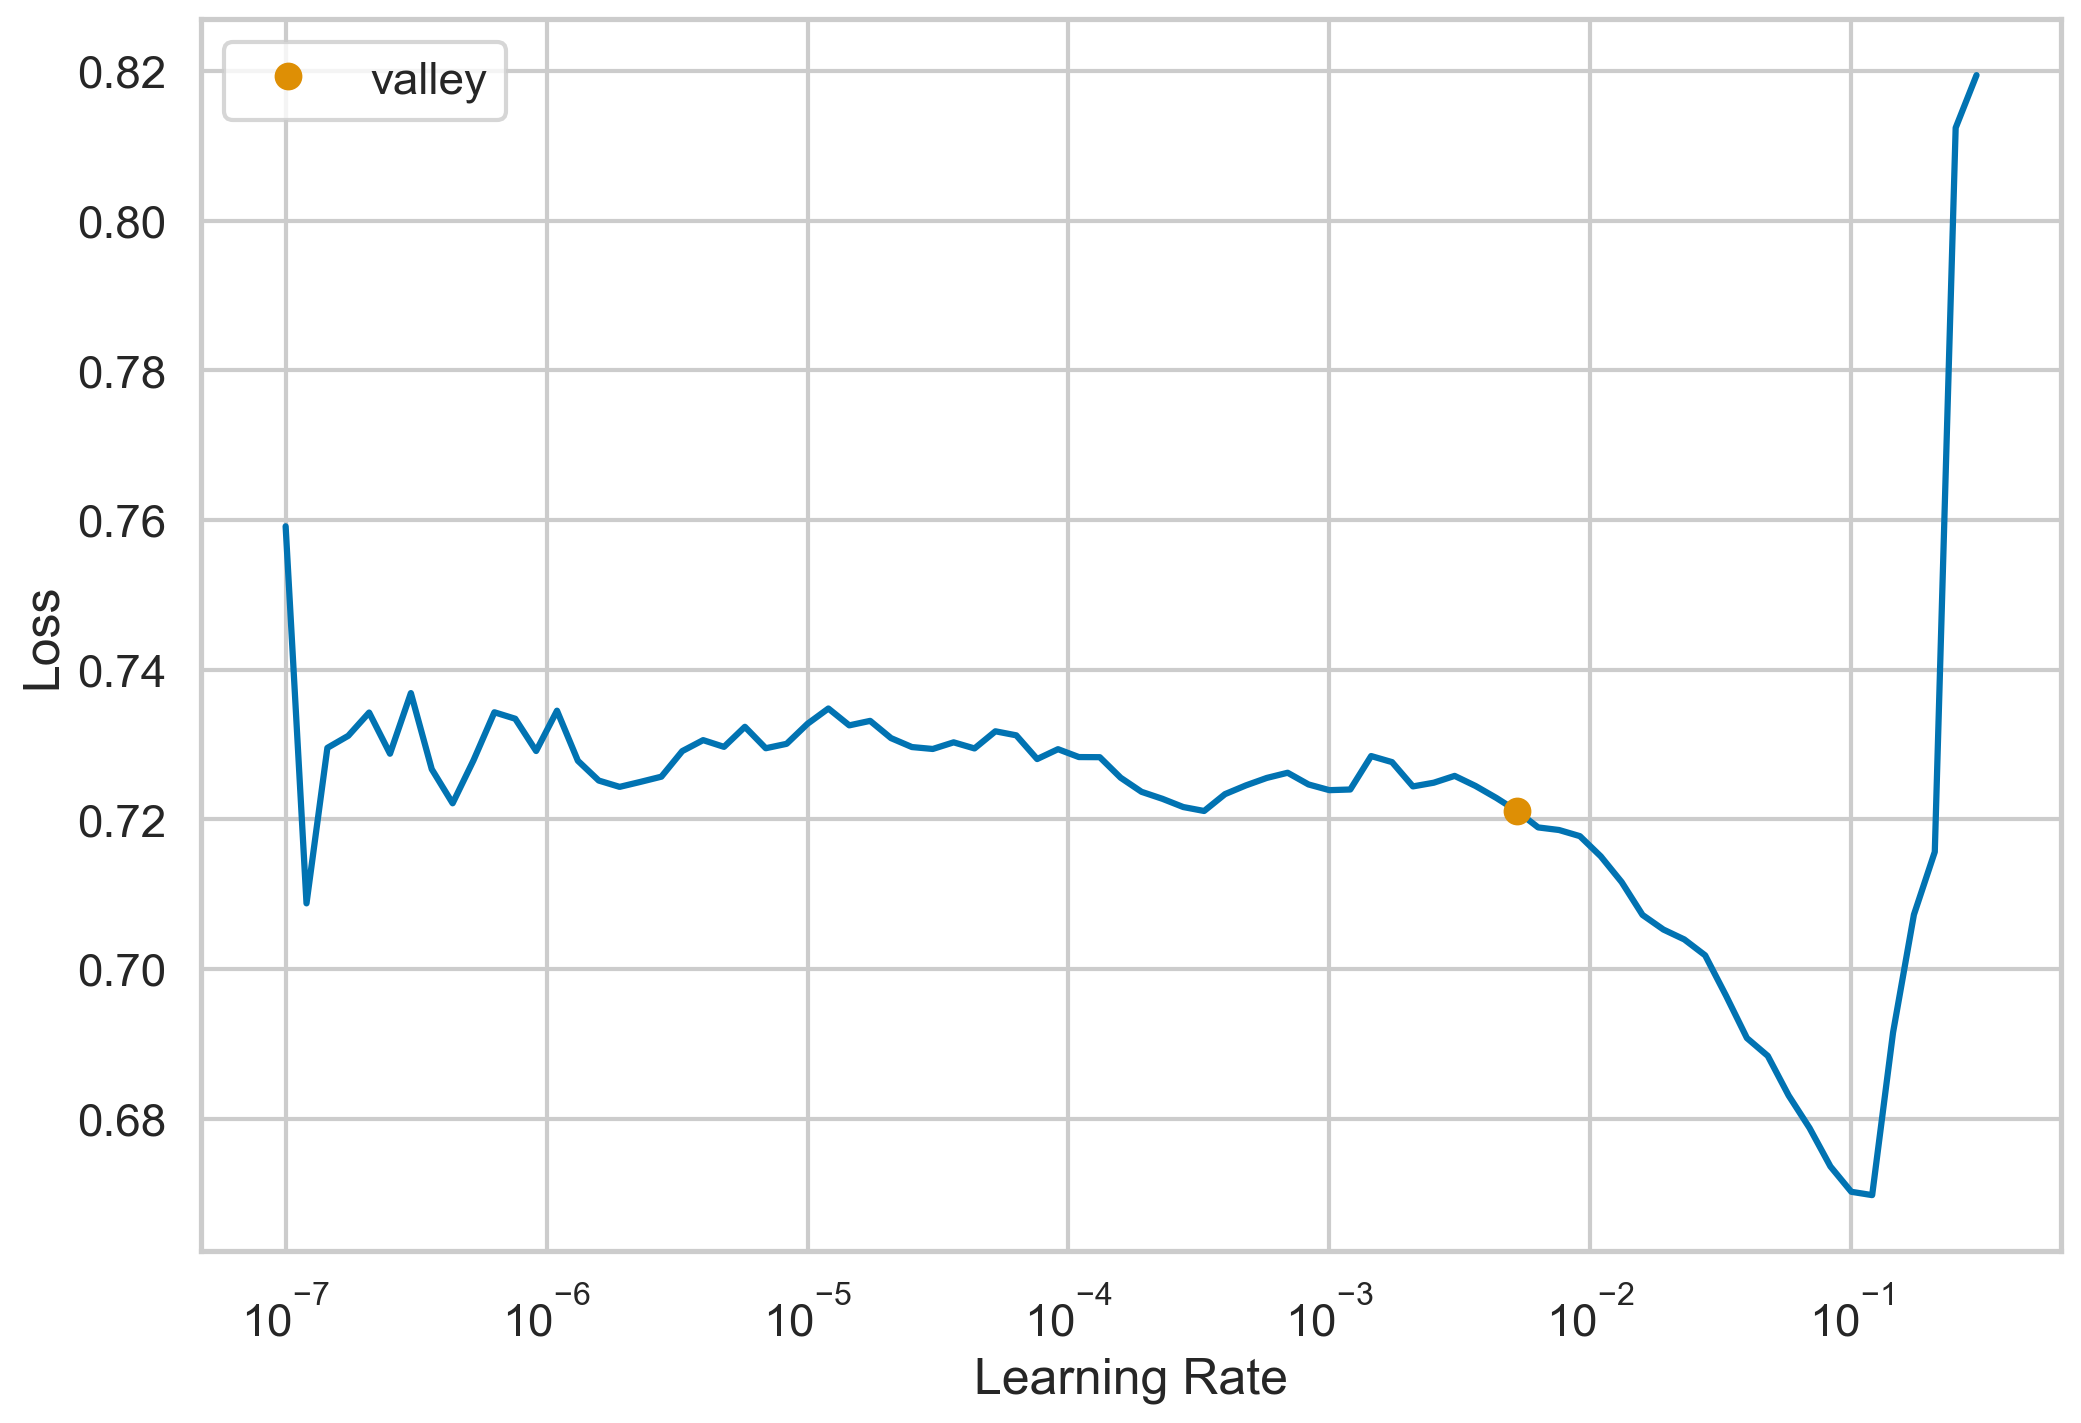

In [15]:
learn.lr_find()

### 9. Train the Tabular learner

In [16]:
learn.fit(n_epoch=25, lr=1e-3, wd=0.2)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,0.449724,0.430393,0.822500,0.323161,0.673736,00:11
1,0.439253,0.450406,0.816667,0.298122,0.652397,00:10
2,0.435387,0.444672,0.822333,0.362285,0.648459,00:09
3,0.438819,0.434389,0.825500,0.391236,0.650195,00:10
4,0.438730,0.445658,0.822167,0.405321,0.627879,00:09
5,0.433187,inf,0.823500,0.388106,0.641656,00:09
6,0.433262,inf,0.813167,0.371674,0.598991,00:09
7,0.452211,inf,0.823500,0.364632,0.653576,00:09
8,0.436150,inf,0.822833,0.332551,0.669291,00:10
9,0.426522,inf,0.820667,0.342723,0.649852,00:10


### 10. Plot the losses

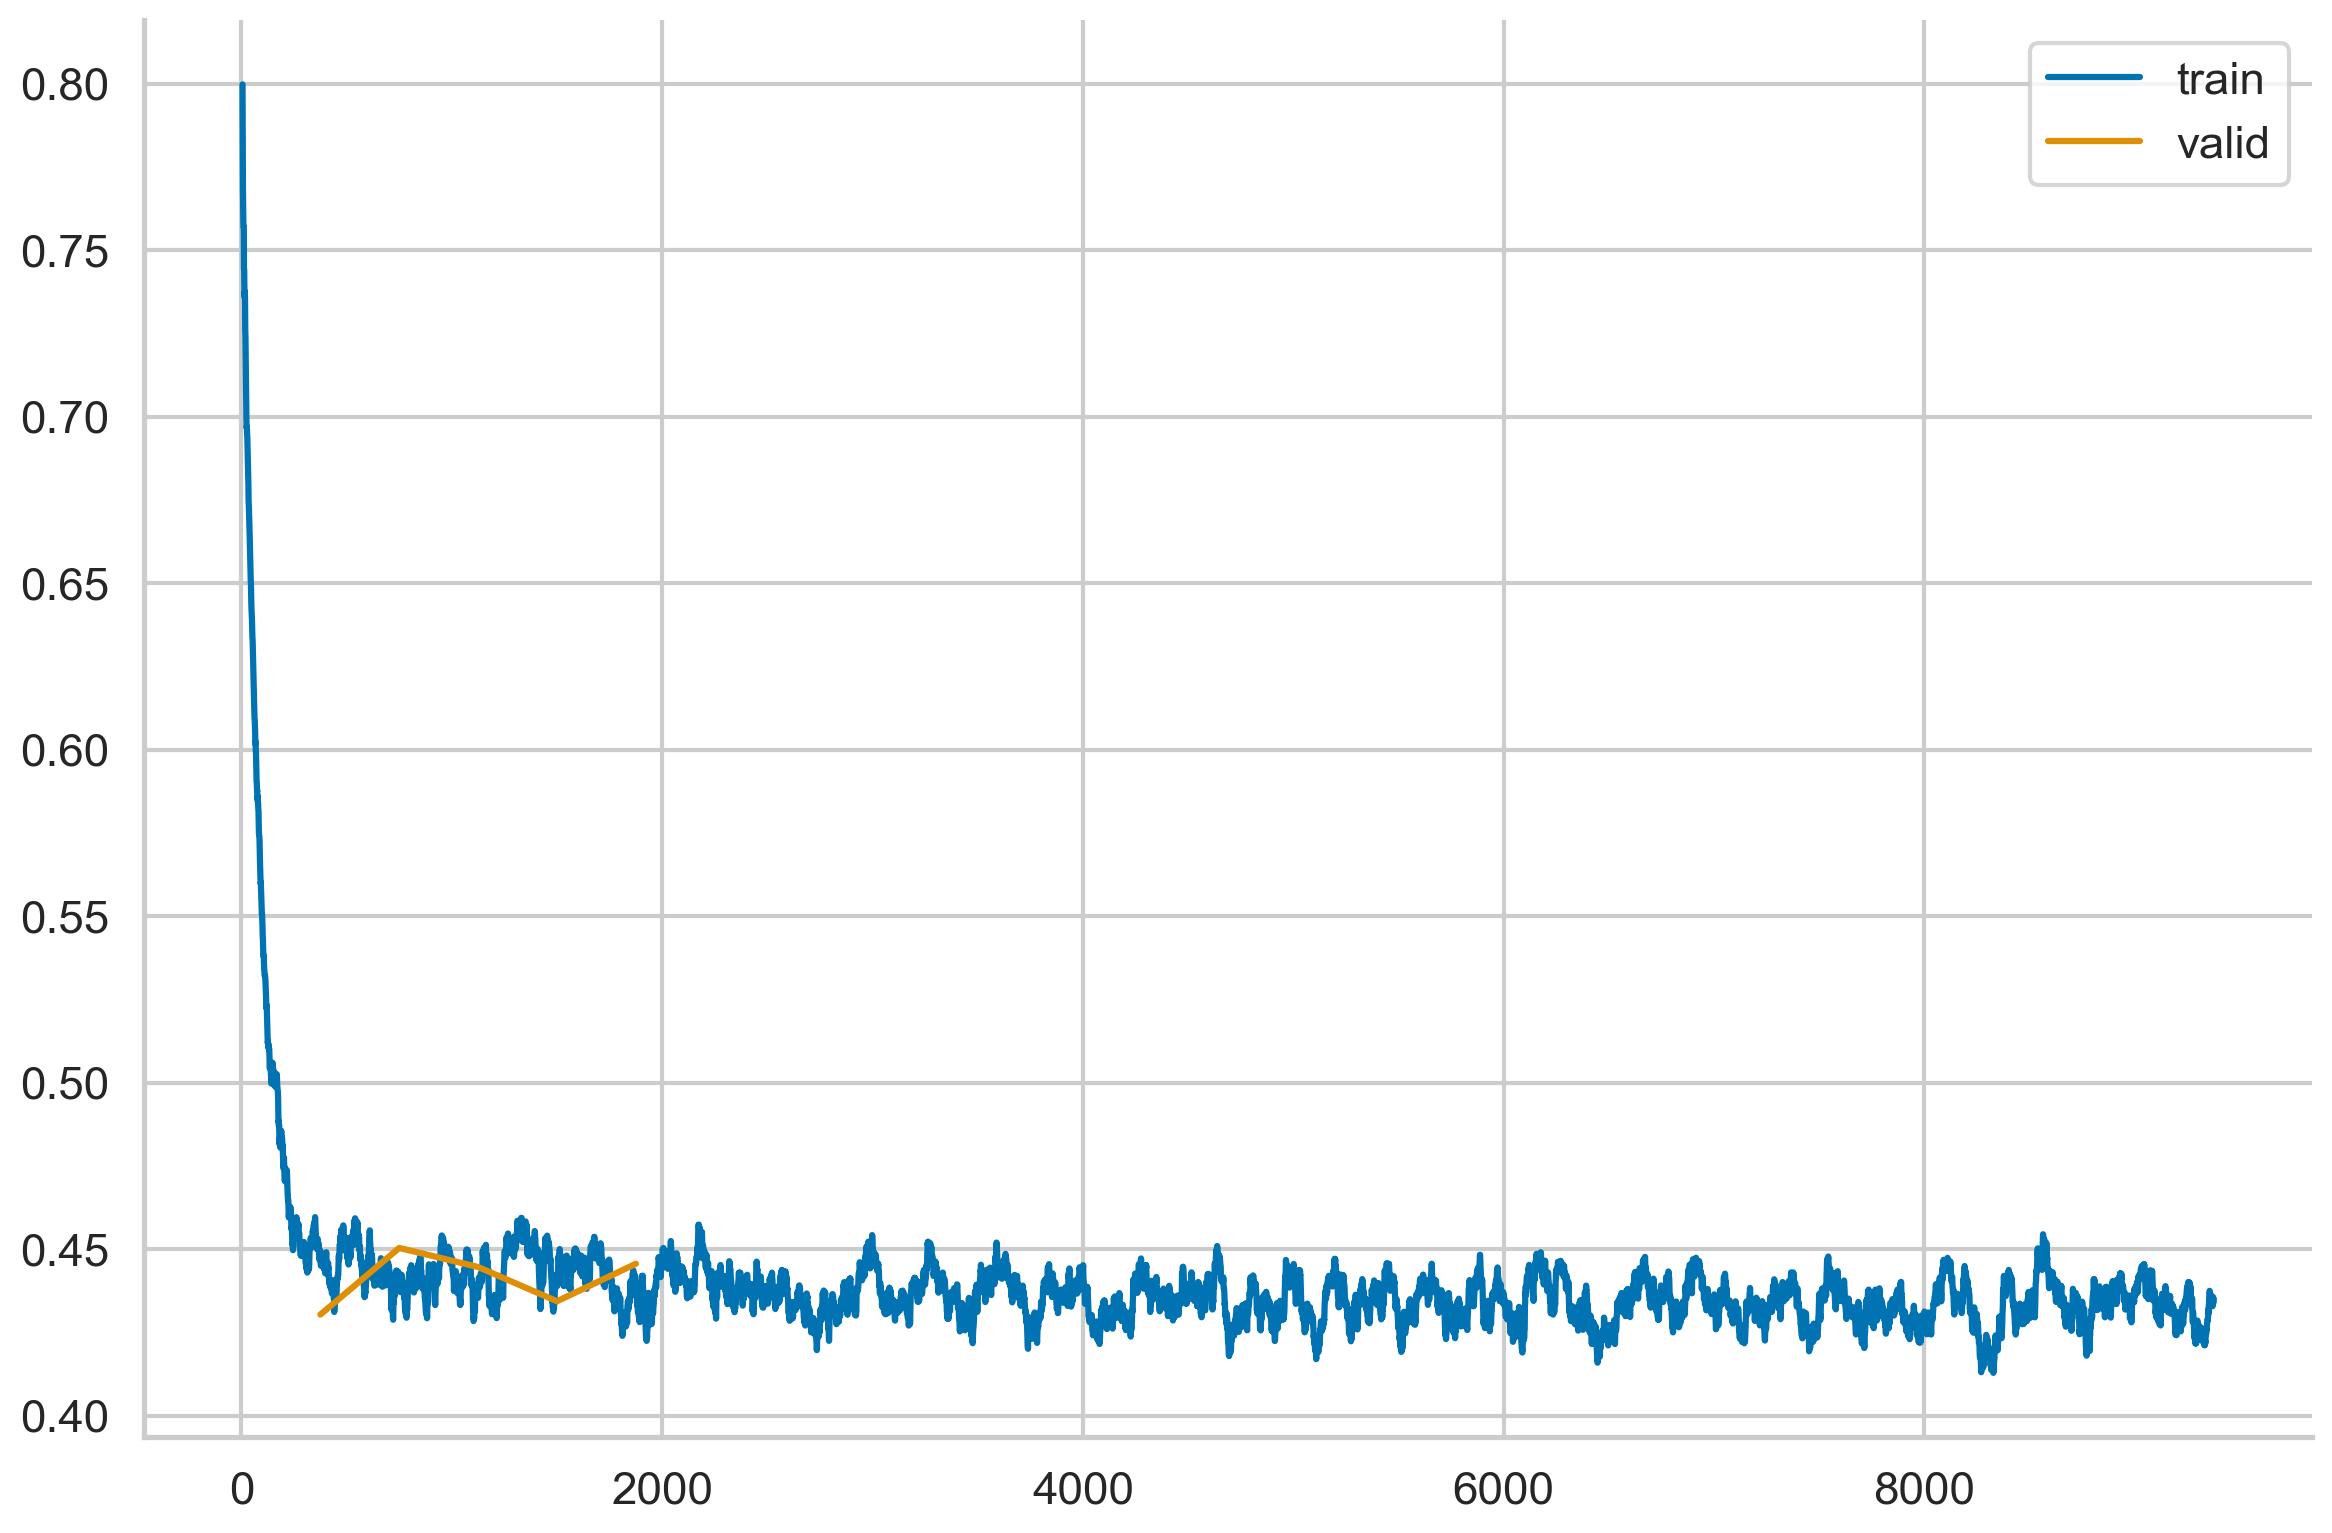

In [17]:
import seaborn as sns

learn.recorder.plot_loss()

plt.tight_layout()
sns.despine()

### 11. Define the validation `DataLoders`

In [18]:
valid_data_loader = learn.dls.test_dl(df.loc[list(splits[1])])
valid_data_loader.show_batch()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,Female,Graduate School,Single,Payment delayed 1 month,Unknown,Unknown,Unknown,Paid duly,Paid duly,False,80000.002671,28.0,0.000274,-0.001422,-0.000269,-0.000013,2284.000497,-786.000871,0.000039,-0.000043,-0.000163,2283.999916,0.000058,-0.000013,1
1,Female,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,360000.000553,44.0,347695.995104,329863.996200,322158.997157,289376.998417,146945.999005,130085.003447,19999.999860,20008.999765,30000.000210,9999.999766,9999.999951,10000.000060,0
2,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,80000.002671,31.0,0.000274,-0.001422,-0.000269,-0.000013,0.001374,0.001333,0.000039,-0.000043,-0.000163,-0.000076,0.000058,-0.000013,0
3,Female,University,Married,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,Paid duly,False,49999.996248,43.0,560.001359,1120.999531,194.999217,196.998524,196.998239,197.000509,1121.000175,194.999828,197.000070,197.000190,196.999852,196.999786,0
4,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,179999.999837,26.0,145574.003103,108616.999401,102710.999113,95651.998160,97661.001694,99655.998778,3906.999985,3600.000028,3414.999937,3541.999967,3615.999970,1999.999949,0
5,Male,University,Single,Payment delayed 2 months,Payment delayed 2 months,Payment delayed 2 months,Paid duly,Unknown,Paid duly,False,20000.005341,37.0,3254.001134,2521.998928,-0.000269,779.998506,390.000193,390.000078,1999.999921,-0.000043,780.000096,-0.000076,389.999981,1679.999945,1
6,Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,279999.998942,44.0,286706.004848,272243.004586,203743.992187,203520.005928,207877.993990,211811.996533,10480.000231,8041.000065,7200.000052,7499.999924,7092.999917,5701.999989,0
7,Male,University,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,80000.002671,26.0,76157.999269,81858.000996,80337.000365,61002.000665,58147.999258,52514.999924,8000.000067,4999.999988,4000.000000,4999.999993,3000.000004,5000.000007,0
8,Male,Graduate School,Married,Unknown,Unknown,Unknown,Paid duly,Paid duly,Paid duly,False,209999.999471,52.0,44933.000212,38541.999976,39331.999888,11140.000617,8462.999592,10406.000874,1792.999970,8242.000014,12000.000196,8533.999995,11000.000119,7500.000042,0
9,Female,Graduate School,Single,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,49999.996248,22.0,49459.000028,49281.000000,50071.000110,10104.000406,9208.000207,10075.000742,2299.999941,2000.000073,1000.000042,500.000082,999.999780,500.000043,0


### 12. Evaluate the performance on the validation set

In [19]:
learn.validate(dl=valid_data_loader)

(#4) [inf,0.8255000114440918,0.3435054773082942,0.678516228748068]

### 13. Get predictions for the validation set

In [20]:
preds, y_true = learn.get_preds(dl=valid_data_loader)

In [21]:
preds

tensor([[0.7737, 0.2263],
        [0.8560, 0.1440],
        [0.8389, 0.1611],
        ...,
        [0.9222, 0.0778],
        [0.8809, 0.1191],
        [0.8824, 0.1176]])

In [22]:
preds.argmax(dim=-1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [23]:
y_true

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

### 14. Inspect the performance evaluation metrics

In [24]:
# auto reload
%load_ext autoreload
%autoreload 2
from evaluation_report import performance_evaluation_report_fastai

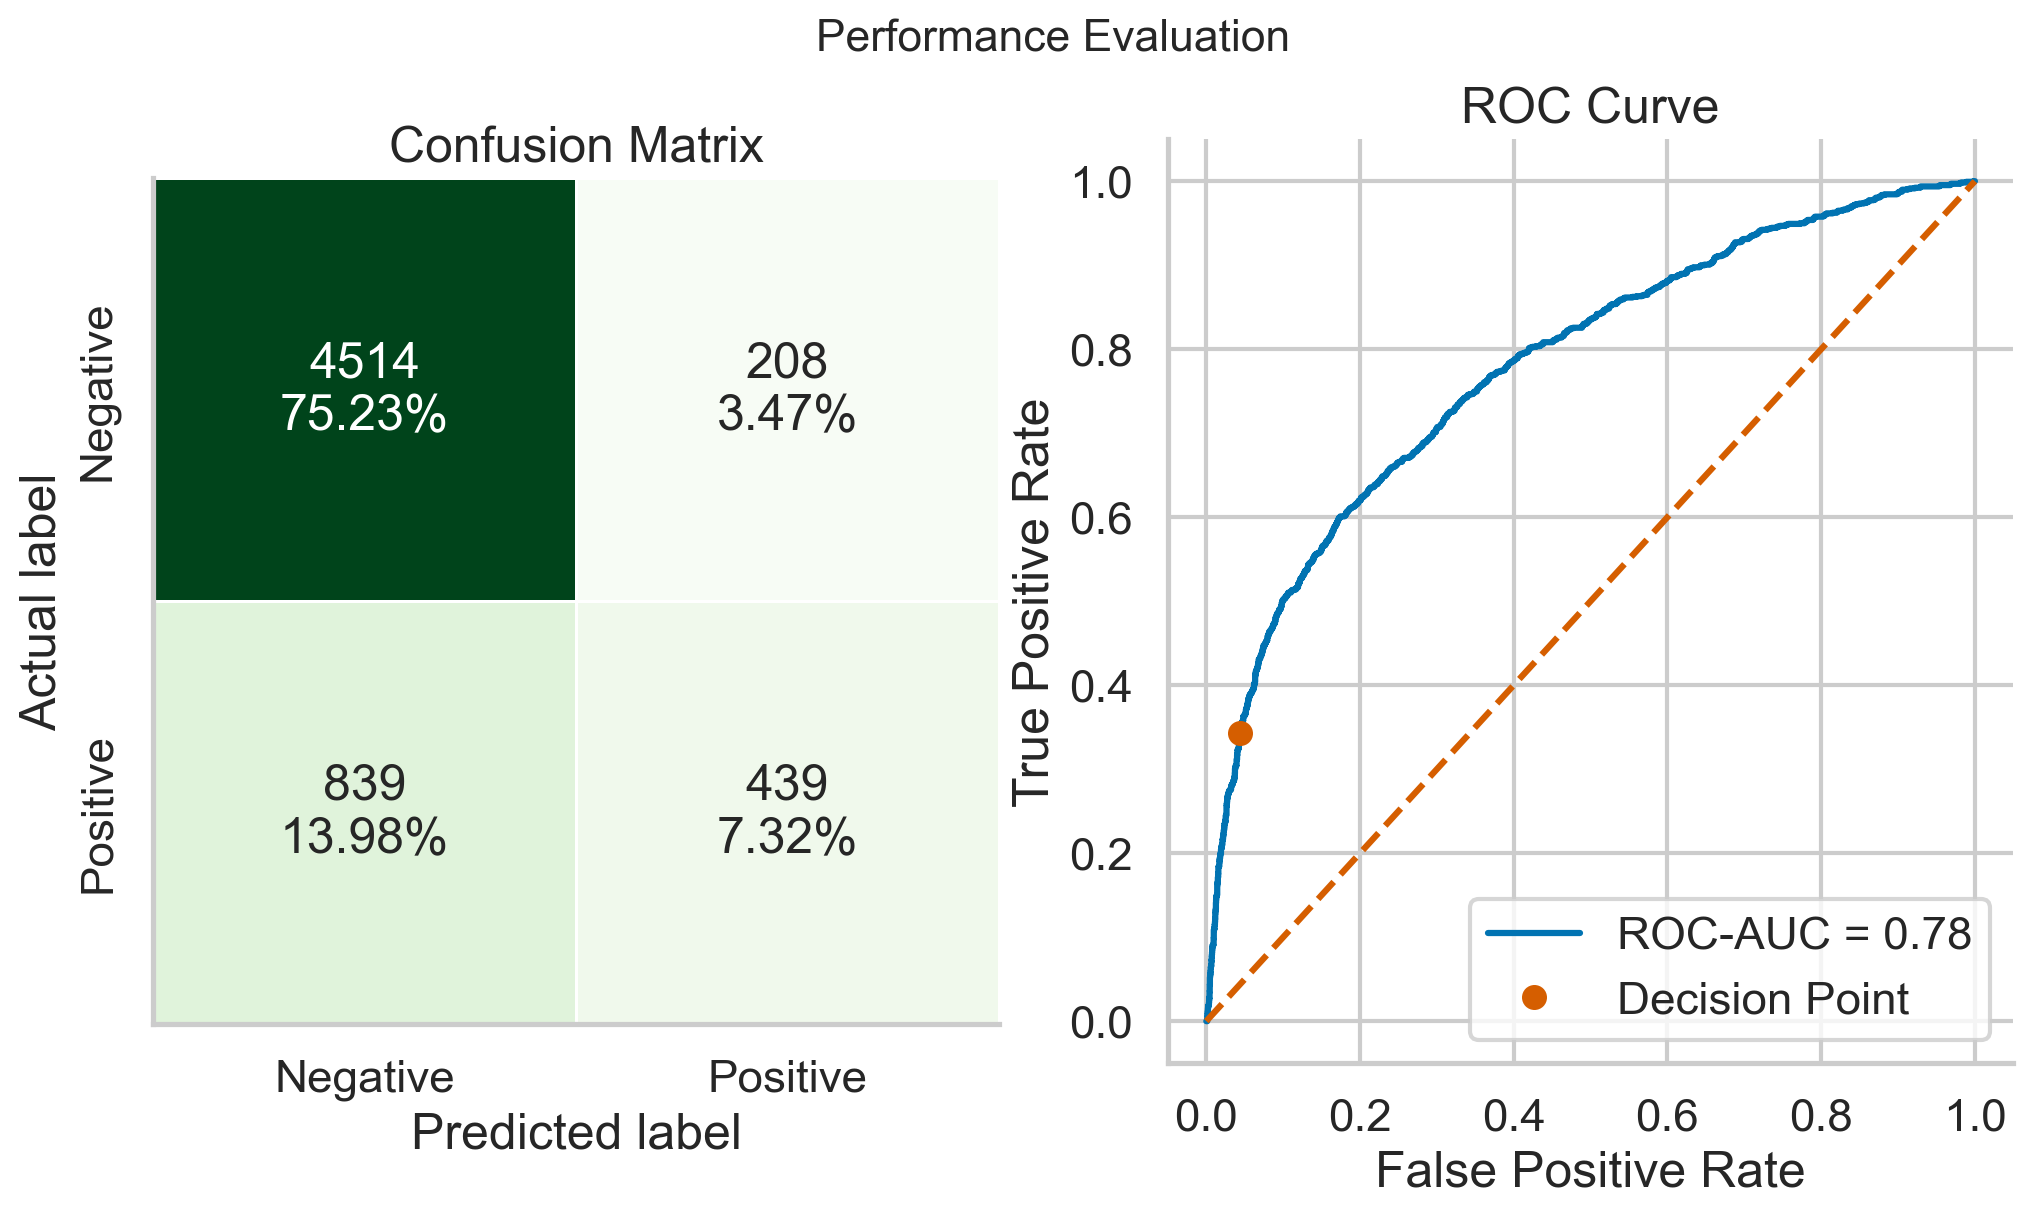

In [25]:
perf = performance_evaluation_report_fastai(
    learn, valid_data_loader, show_plot=True
)

sns.despine()

In [26]:
perf

{'accuracy': 0.8255,
 'precision': 0.678516228748068,
 'recall': 0.3435054773082942,
 'specificity': 0.9559508682761542,
 'f1_score': 0.4561038961038961,
 'cohens_kappa': 0.3652152508400137,
 'matthews_corr_coeff': 0.39528576662021137,
 'roc_auc': 0.7790398918524086,
 'pr_auc': 0.5296525663851938,
 'average_precision': 0.53030482822572}

## There's more

In [27]:
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(TARGET)

stat_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_ind, test_ind = next(stat_split.split(X, y))
ind_splits = IndexSplitter(valid_idx=list(test_ind))(range_of(df))

tabular_df = TabularPandas(
    df,
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=ind_splits
)

In [28]:
# we can look into the example results

learn.show_results()

,sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month,default_payment_next_month_pred
0,1.0,1.0,3.0,10.0,10.0,10.0,10.0,1.0,1.0,1.0,0.631809,-0.593439,-0.404412,-0.355582,-0.139882,-0.262525,-0.583205,-0.489190,-0.131044,0.391935,0.149923,-0.000242,0.327373,-0.011857,0.0,0.0
1,1.0,4.0,3.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.443899,-1.464050,-0.696168,-0.691244,-0.677017,-0.672893,-0.663007,-0.651923,-0.339855,-0.254758,-0.298697,-0.304028,-0.318804,-0.126095,0.0,0.0
2,1.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,9.0,1.0,-0.367063,0.821304,-0.668319,-0.667092,-0.666714,-0.658466,-0.663007,-0.651923,-0.308593,-0.224000,-0.246012,-0.304028,-0.318804,-0.268466,0.0,0.0
3,1.0,1.0,1.0,3.0,10.0,10.0,10.0,9.0,9.0,1.0,-1.058589,-0.049307,-0.321110,-0.288104,-0.287818,-0.258584,-0.269046,-0.259323,-0.250365,-0.196507,-0.247491,-0.241210,-0.245185,-0.258292,1.0,1.0
4,1.0,4.0,1.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,0.708645,0.494824,2.596349,2.937482,1.885730,0.530134,0.646087,0.721462,0.853832,0.067429,-0.128011,-0.084166,-0.077533,-0.082900,0.0,0.0
5,1.0,4.0,3.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.213390,-0.702266,-0.423908,-0.451377,-0.405608,-0.361351,-0.312941,-0.296539,-0.160874,-0.125883,-0.128011,-0.084166,-0.184951,-0.182361,0.0,0.0
6,2.0,1.0,3.0,3.0,3.0,10.0,10.0,9.0,9.0,1.0,-0.751244,-0.593439,-0.222522,-0.212323,-0.169495,-0.112223,-0.054013,-0.017489,-0.339855,-0.168841,-0.224733,-0.209801,-0.218414,-0.206459,1.0,1.0
7,2.0,4.0,1.0,10.0,10.0,10.0,10.0,9.0,9.0,1.0,-0.904917,-1.028745,-0.311132,-0.365456,-0.367908,-0.391997,-0.354343,-0.336771,-0.254183,-0.204840,-0.174437,-0.249314,-0.285341,-0.296031,0.0,0.0
8,2.0,4.0,3.0,2.0,3.0,10.0,10.0,2.0,9.0,1.0,-0.904917,-0.484613,-0.037423,-0.058980,0.009550,-0.367739,-0.347116,-0.313966,-0.339855,-0.070037,-0.176372,-0.304028,-0.238225,-0.239196,0.0,0.0


In [29]:
# or create predictions for a single row

row, clas, probs = learn.predict(df.iloc[0])

In [30]:
row

   sex  education  marriage  payment_status_sep  payment_status_aug  \
0  1.0        4.0       1.0                 3.0                 3.0   

   payment_status_jul  payment_status_jun  payment_status_may  \
0                 1.0                 1.0                 9.0   

   payment_status_apr  age_na  ...  bill_statement_jun  bill_statement_may  \
0                 9.0     1.0  ...           -0.672893           -0.663007   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0           -0.651923             -0.339855              -0.22516   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0             -0.298697             -0.304028             -0.318804   

   previous_payment_apr  default_payment_next_month  
0             -0.296031                         1.0  

[1 rows x 25 columns]

In [31]:
clas

tensor(1)

In [32]:
probs

tensor([0.4651, 0.5349])

# Exploring Google's TabNet

## How to do it

### 1. Import the libraries

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import torch
import pandas as pd
import numpy as np

### 2. Load the dataset from CSV file

In [34]:
df = pd.read_csv('./datasets/credit_card_default.csv', na_values="")

### 3. Separate the target from the features and create lists with numerical/categorical features

In [35]:
X = df.copy()
y = X.pop("default_payment_next_month")
cat_features = list(X.select_dtypes("object").columns)
num_features = list(X.select_dtypes("number").columns)

In [36]:
# as a reminder, where the possible missing values are
X.isna().any()

limit_bal               False
sex                      True
education                True
marriage                 True
age                      True
payment_status_sep      False
payment_status_aug      False
payment_status_jul      False
payment_status_jun      False
payment_status_may      False
payment_status_apr      False
bill_statement_sep      False
bill_statement_aug      False
bill_statement_jul      False
bill_statement_jun      False
bill_statement_may      False
bill_statement_apr      False
previous_payment_sep    False
previous_payment_aug    False
previous_payment_jul    False
previous_payment_jun    False
previous_payment_may    False
previous_payment_apr    False
dtype: bool

### 4. Impute missing values in the categorical features, encode them using `LabelEncoder`, and store the number of unique categories per feature.

In [37]:
cat_dims = {}
for col in cat_features:
    label_encoder = LabelEncoder()
    X[col] = X[col].fillna("Missing")
    X[col] = label_encoder.fit_transform(X[col].values)
    cat_dims[col] = len(label_encoder.classes_)
cat_dims

{'sex': 3,
 'education': 5,
 'marriage': 4,
 'payment_status_sep': 10,
 'payment_status_aug': 10,
 'payment_status_jul': 10,
 'payment_status_jun': 10,
 'payment_status_may': 9,
 'payment_status_apr': 9}

### 5. Create a train/valid/test split using the 70-15-15 split

In [38]:
# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,
    stratify=y,
    random_state=42
)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

In [39]:
print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_valid) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_valid.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
Train: 70.00%
Valid: 15.00%
Test: 15.00%

Class distribution in each set ----
Train: [0.77880952 0.22119048]
Valid: [0.77888889 0.22111111]
Test: [0.77866667 0.22133333]


### 6. Impute the missing values in the numerical features across all the sets

In [40]:
for col in num_features:
    imp_mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(imp_mean)
    X_valid[col] = X_valid[col].fillna(imp_mean)
    X_test[col] = X_test[col].fillna(imp_mean)

### 7. Prepare lists with the indices of categorical features and the number of unique categories

In [41]:
features = X.columns.to_list()
cat_ind = [features.index(feat) for feat in cat_features]
cat_dims = list(cat_dims.values())
cat_ind

[1, 2, 3, 5, 6, 7, 8, 9, 10]

### 8. Define a custom recall metric

In [42]:
class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return recall_score(y_true, y_pred)

### 9. Define TabNet’s parameters and instantiate the classifier

In [43]:
tabnet_params = {
    "cat_idxs": cat_ind,
    "cat_dims": cat_dims,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {
        "step_size": 20,
        "gamma": 0.9
    },
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "sparsemax",
    "seed": 42
}

tabnet = TabNetClassifier(**tabnet_params)

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


### 10.Train the TabNet classifier

In [44]:
tabnet.fit(
    X_train = X_train.values,
    y_train = y_train.values,
    eval_set = [
        (X_train.values, y_train.values),
        (X_valid.values, y_valid.values)
    ],
    eval_name=["train", "valid"],
    eval_metric=["auc", Recall],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    weights=1
)

epoch 0  | loss: 0.69395 | train_auc: 0.63377 | train_recall: 0.53154 | valid_auc: 0.61624 | valid_recall: 0.49347 |  0:00:01s
epoch 1  | loss: 0.62933 | train_auc: 0.68349 | train_recall: 0.47126 | valid_auc: 0.66452 | valid_recall: 0.42613 |  0:00:02s
epoch 2  | loss: 0.60389 | train_auc: 0.7032  | train_recall: 0.52207 | valid_auc: 0.70171 | valid_recall: 0.48945 |  0:00:04s
epoch 3  | loss: 0.59829 | train_auc: 0.73087 | train_recall: 0.52939 | valid_auc: 0.73579 | valid_recall: 0.49648 |  0:00:06s
epoch 4  | loss: 0.58541 | train_auc: 0.73734 | train_recall: 0.60969 | valid_auc: 0.73777 | valid_recall: 0.59698 |  0:00:07s
epoch 5  | loss: 0.58523 | train_auc: 0.74898 | train_recall: 0.52379 | valid_auc: 0.74318 | valid_recall: 0.49146 |  0:00:08s
epoch 6  | loss: 0.58585 | train_auc: 0.75048 | train_recall: 0.55285 | valid_auc: 0.74907 | valid_recall: 0.53166 |  0:00:10s
epoch 7  | loss: 0.58394 | train_auc: 0.75935 | train_recall: 0.53369 | valid_auc: 0.75168 | valid_recall: 0.51

/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### 11. Prepare the history DataFrame and plot the scores over epochs

In [45]:
history_df = pd.DataFrame(tabnet.history.history)
history_df.head(10)

,loss,lr,train_auc,train_recall,valid_auc,valid_recall
0,0.693948,0.02,0.633772,0.531539,0.616238,0.493467
1,0.629334,0.02,0.683494,0.471259,0.664523,0.426131
2,0.603894,0.02,0.703203,0.522067,0.701710,0.489447
3,0.598290,0.02,0.730868,0.529386,0.735792,0.496482
4,0.585413,0.02,0.737340,0.609688,0.737766,0.596985
5,0.585231,0.02,0.748980,0.523789,0.743178,0.491457
6,0.585850,0.02,0.750483,0.552853,0.749066,0.531658
7,0.583941,0.02,0.759347,0.533692,0.751679,0.512563
8,0.575723,0.02,0.763152,0.533907,0.753129,0.509548
9,0.573582,0.02,0.765134,0.550484,0.754963,0.526633


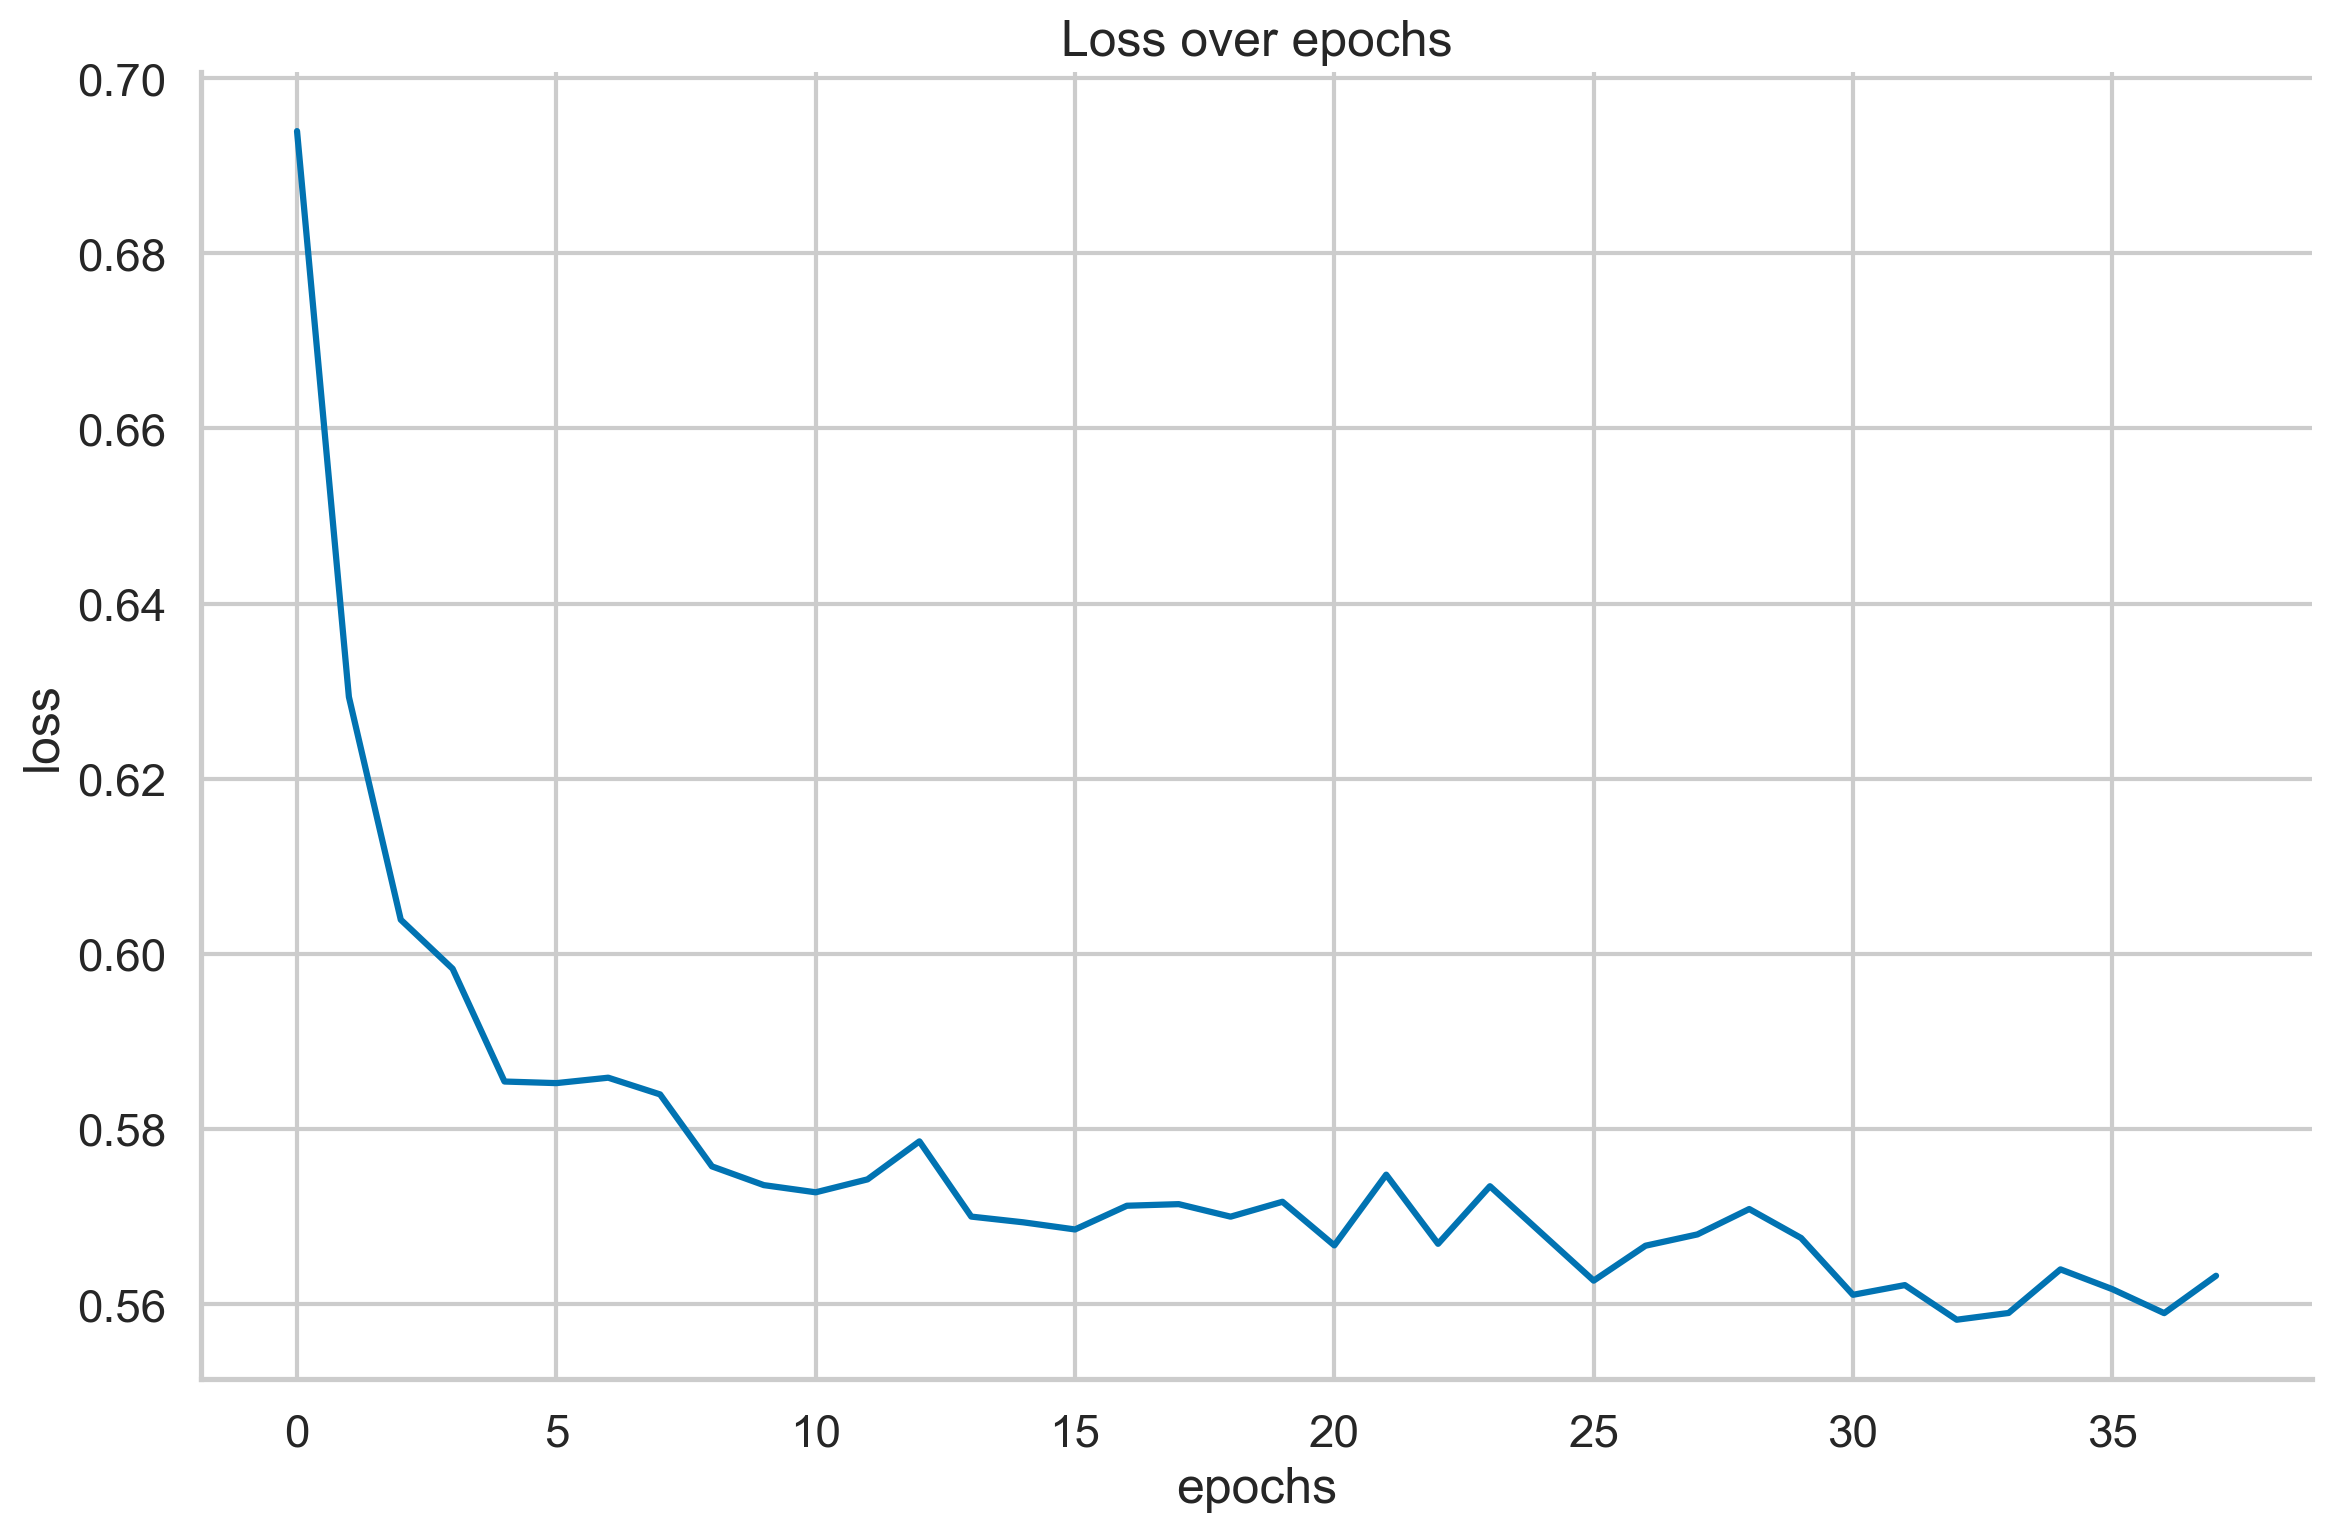

In [46]:
history_df["loss"].plot(
    title="Loss over epochs",
    xlabel="epochs",
    ylabel="loss"
)
plt.tight_layout()
sns.despine()

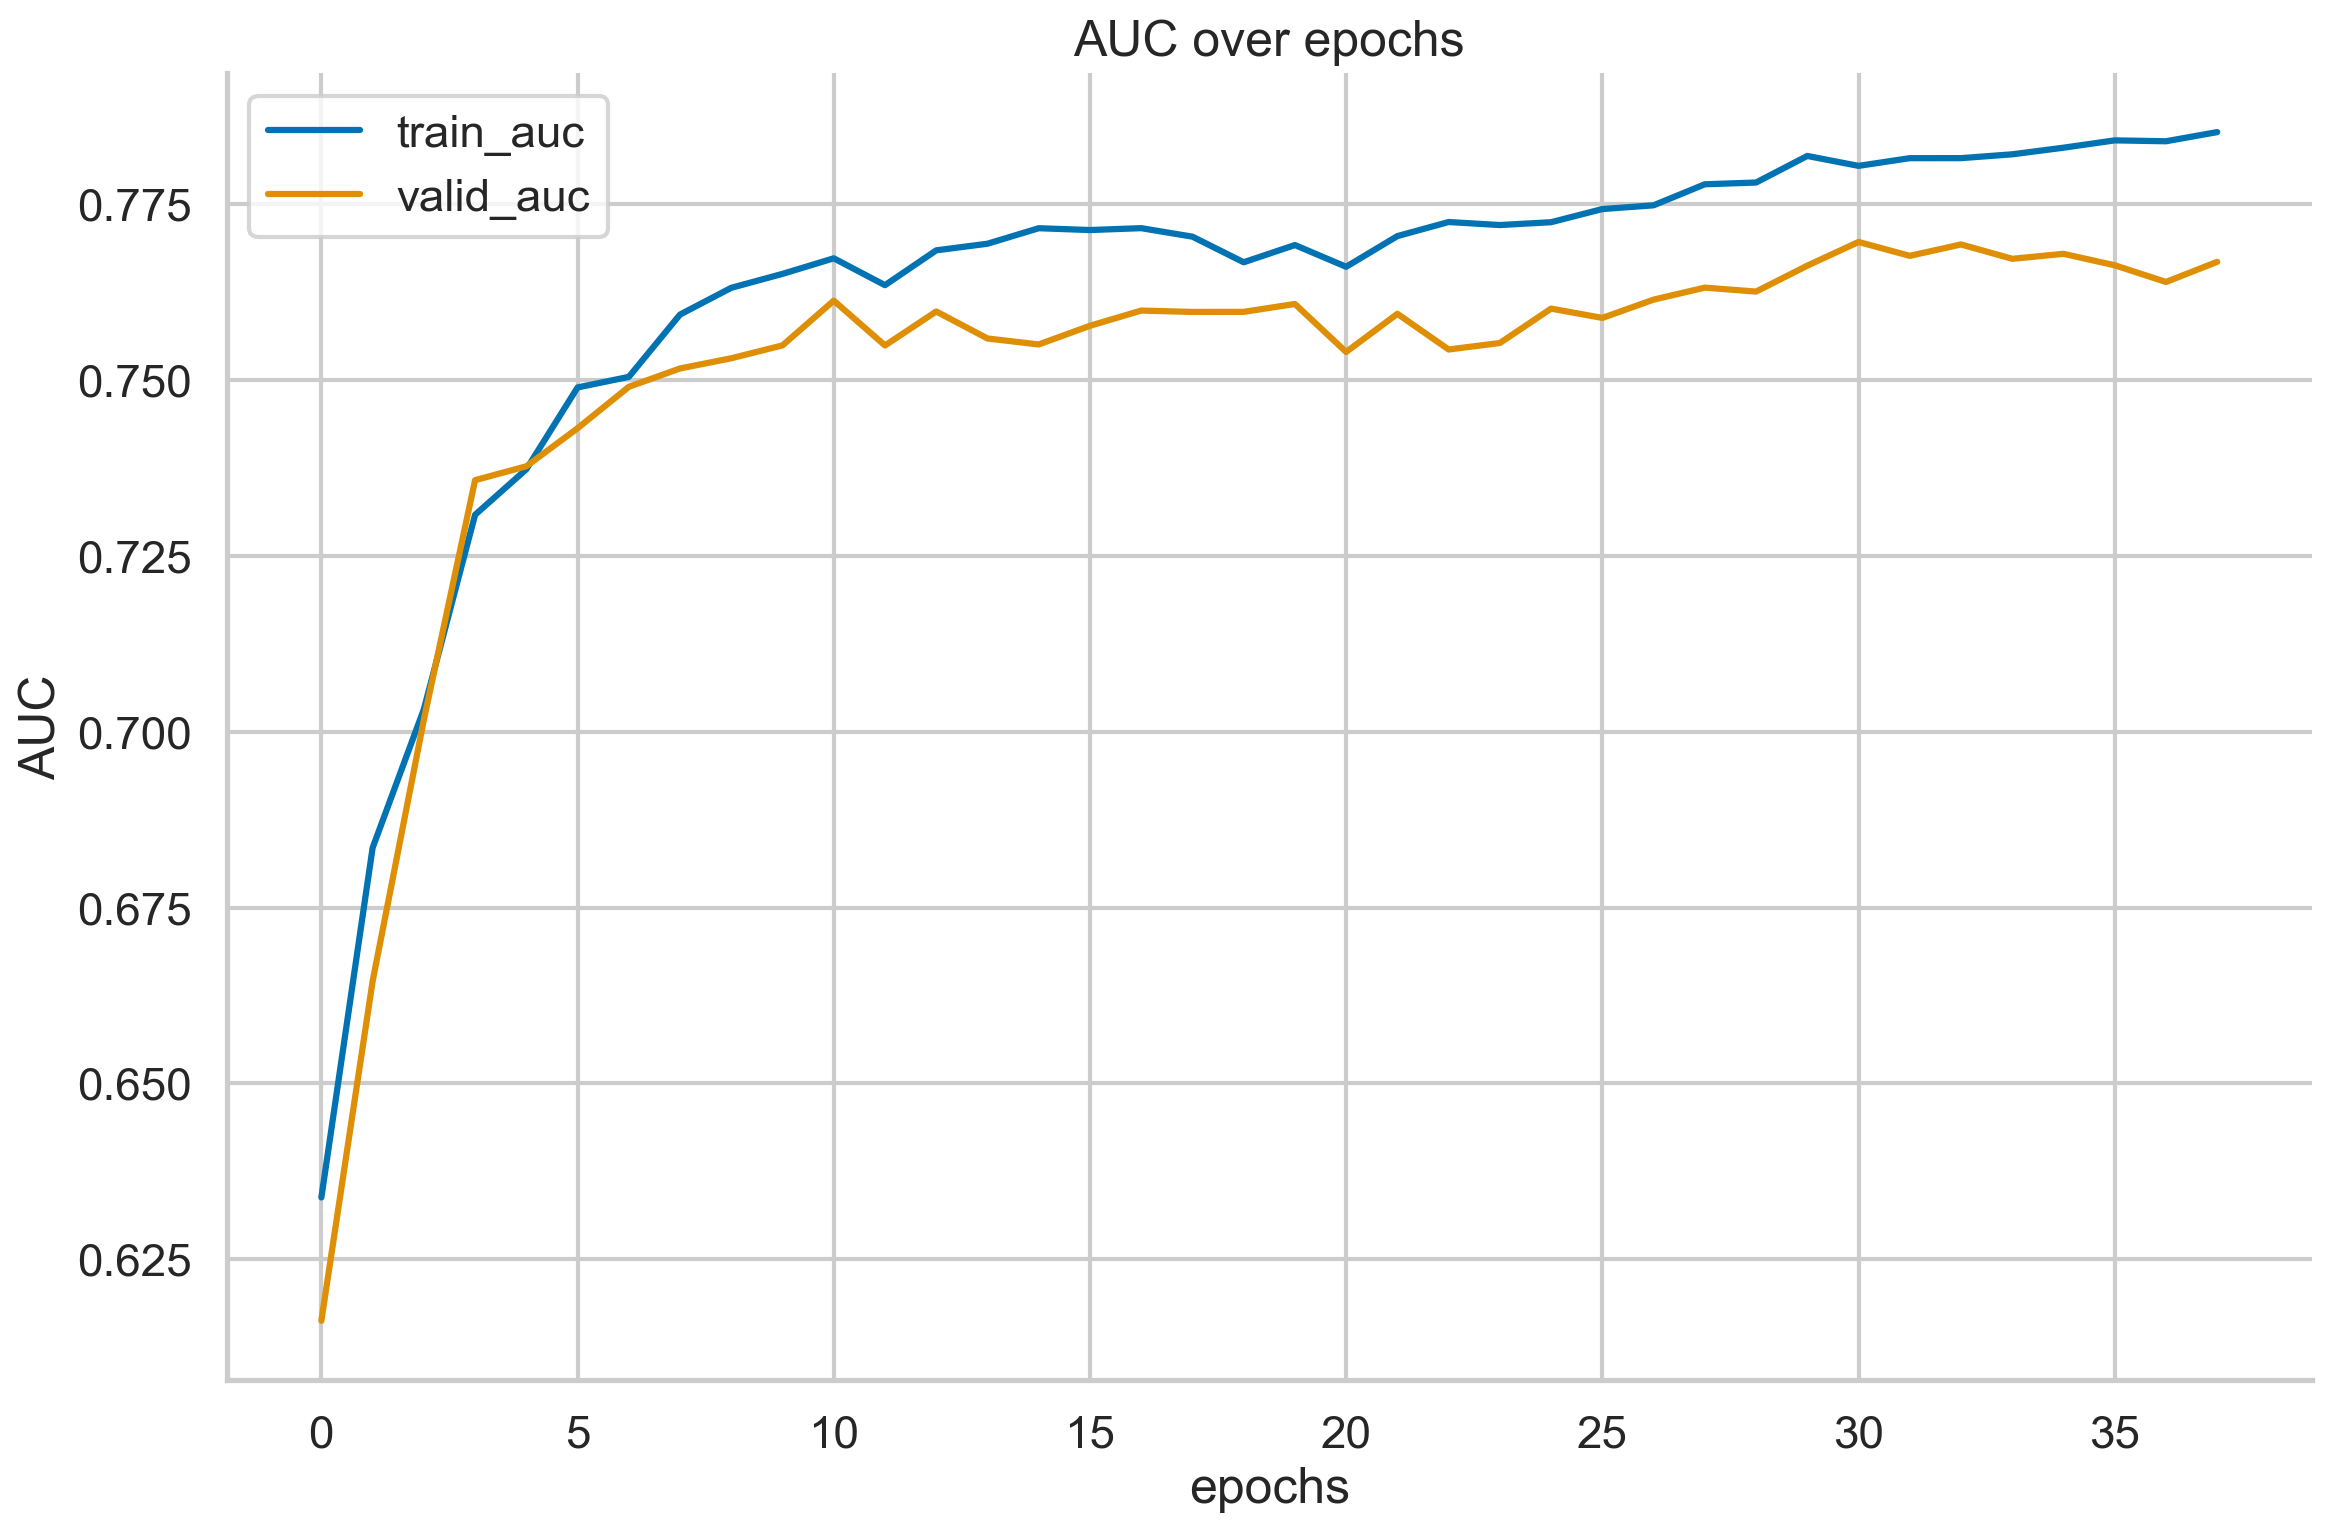

In [47]:
(
    history_df[["train_auc", "valid_auc"]]
    .plot(title="AUC over epochs",
          xlabel="epochs",
          ylabel="AUC")
)
plt.tight_layout()
sns.despine()

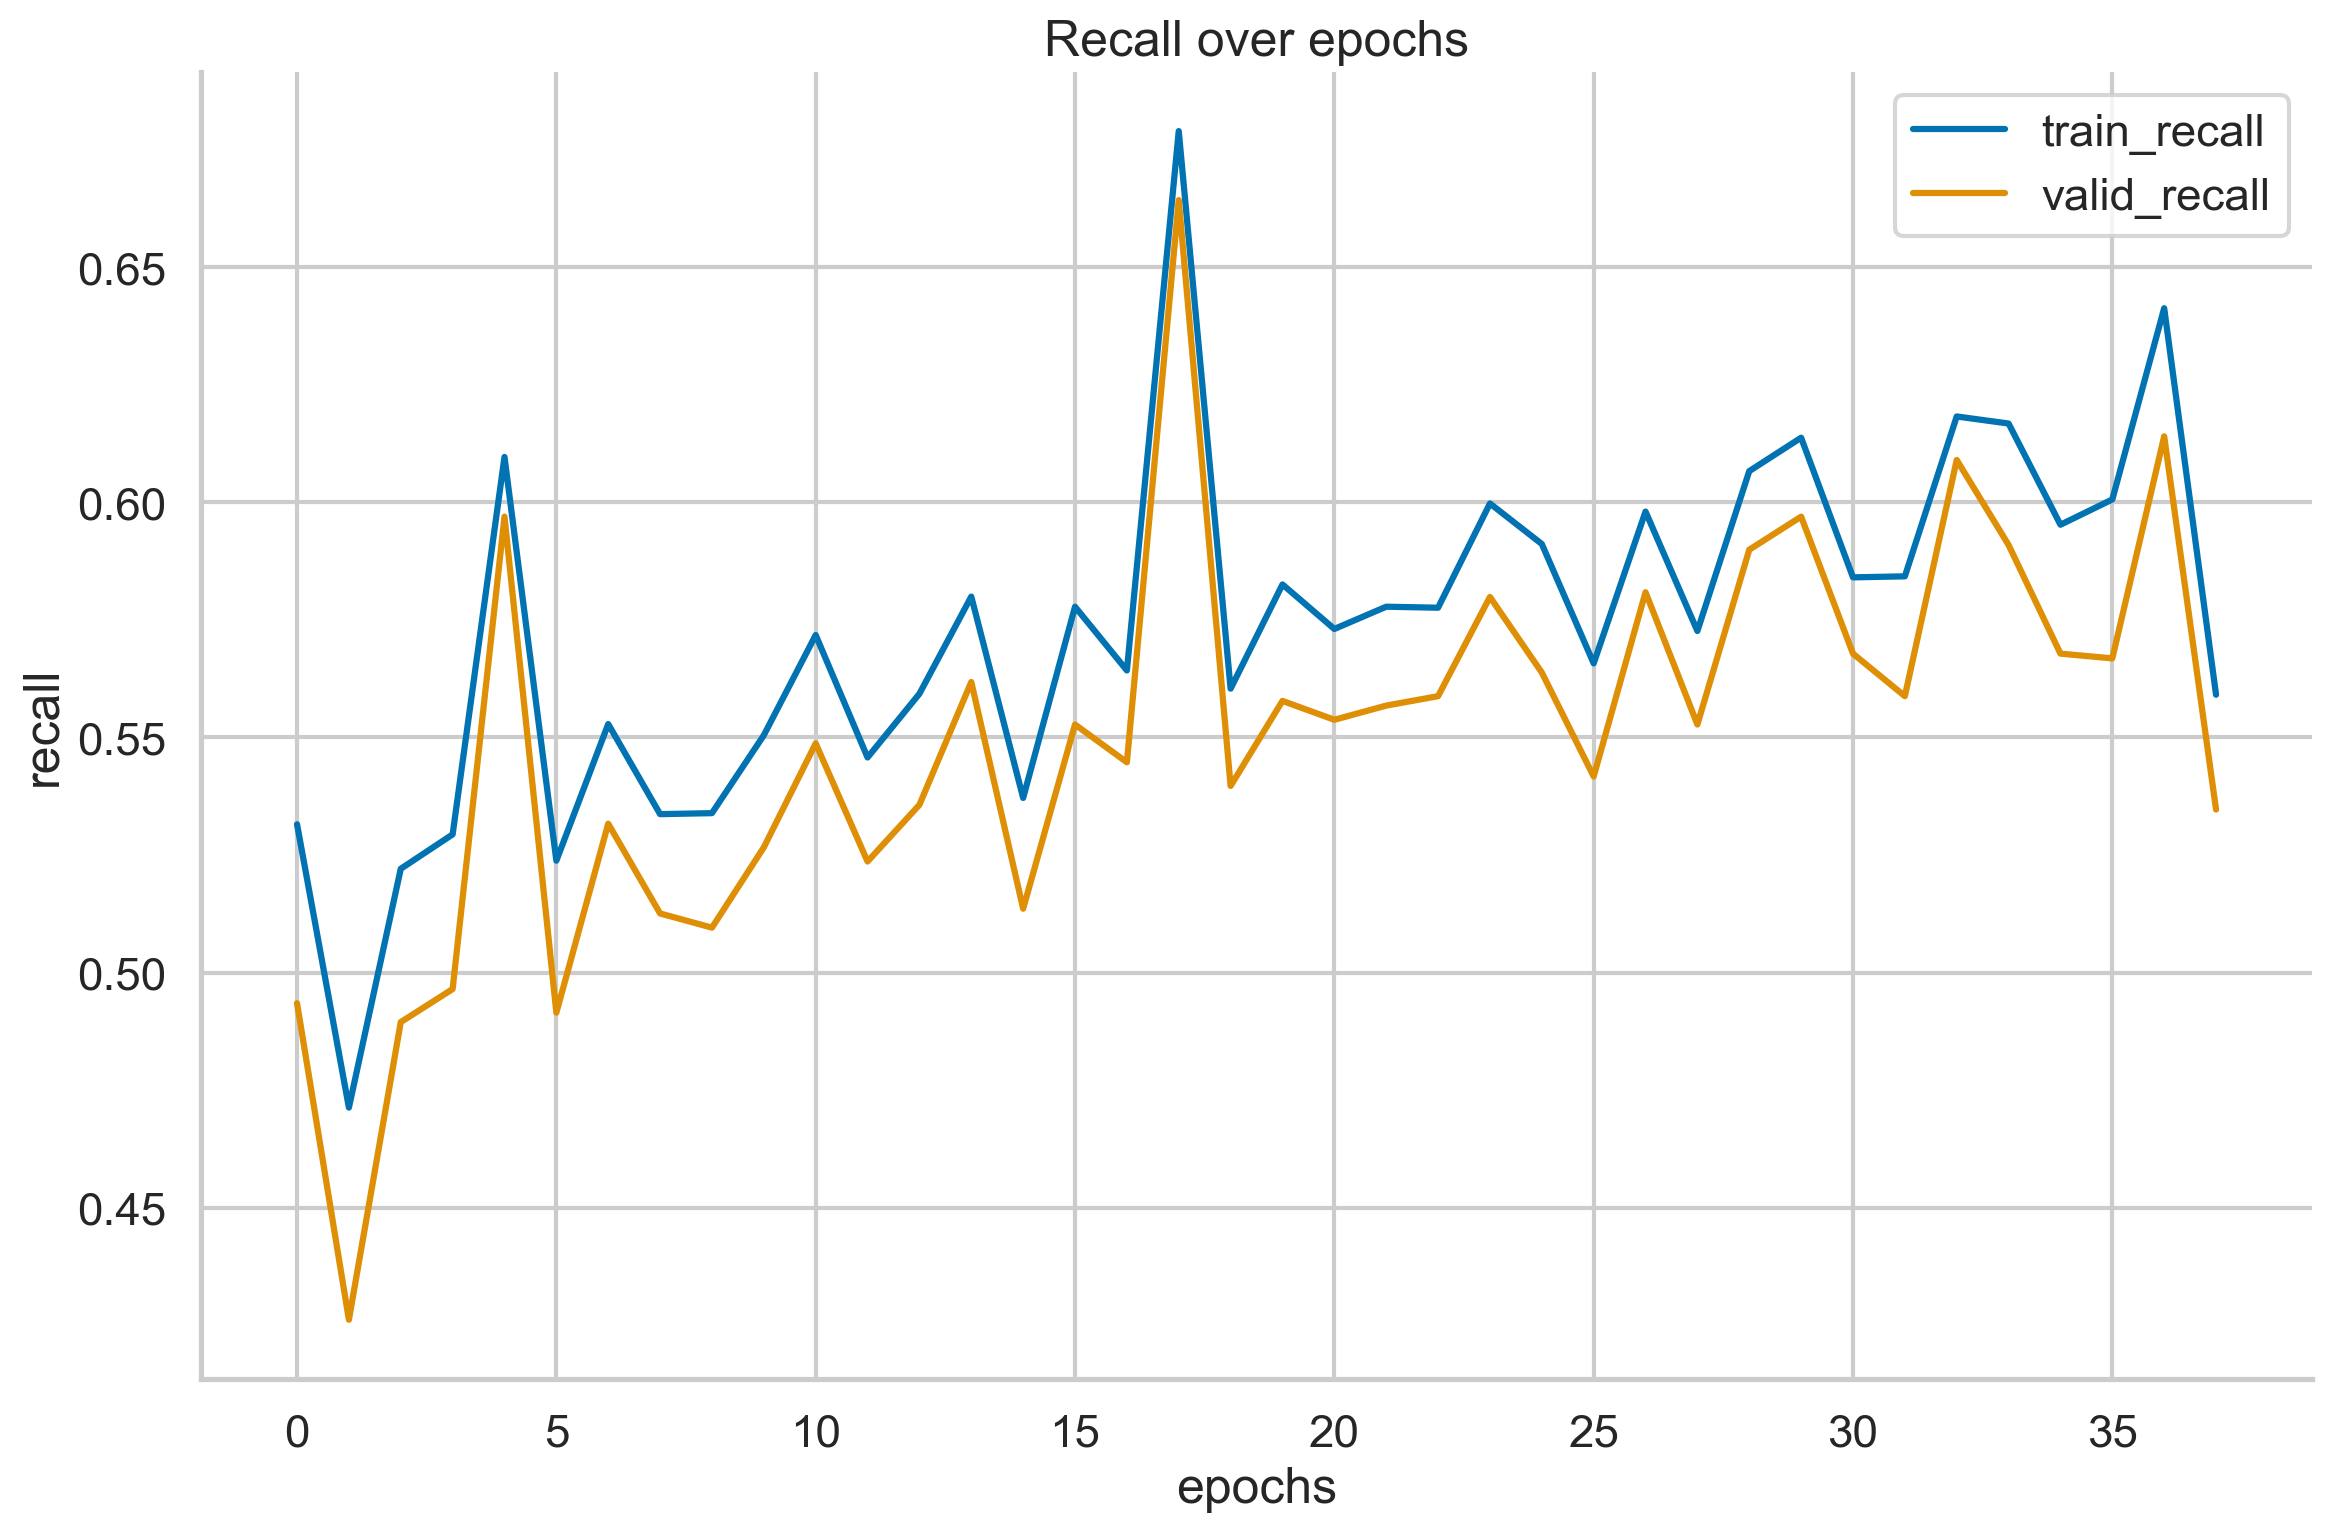

In [48]:
(
    history_df[["train_recall", "valid_recall"]]
    .plot(title="Recall over epochs",
          xlabel="epochs",
          ylabel="recall")
)
plt.tight_layout()
sns.despine()

### 12. Create predictions for the test set and evaluate their performance

In [49]:
y_pred = tabnet.predict(X_test.values)

print(f"Best validation score: {tabnet.best_cost:.4f}")
print(f"Test set score: {recall_score(y_test, y_pred):.4f}")

Best validation score: 0.6643
Test set score: 0.6767


### 13. Extract and plot the global feature importance

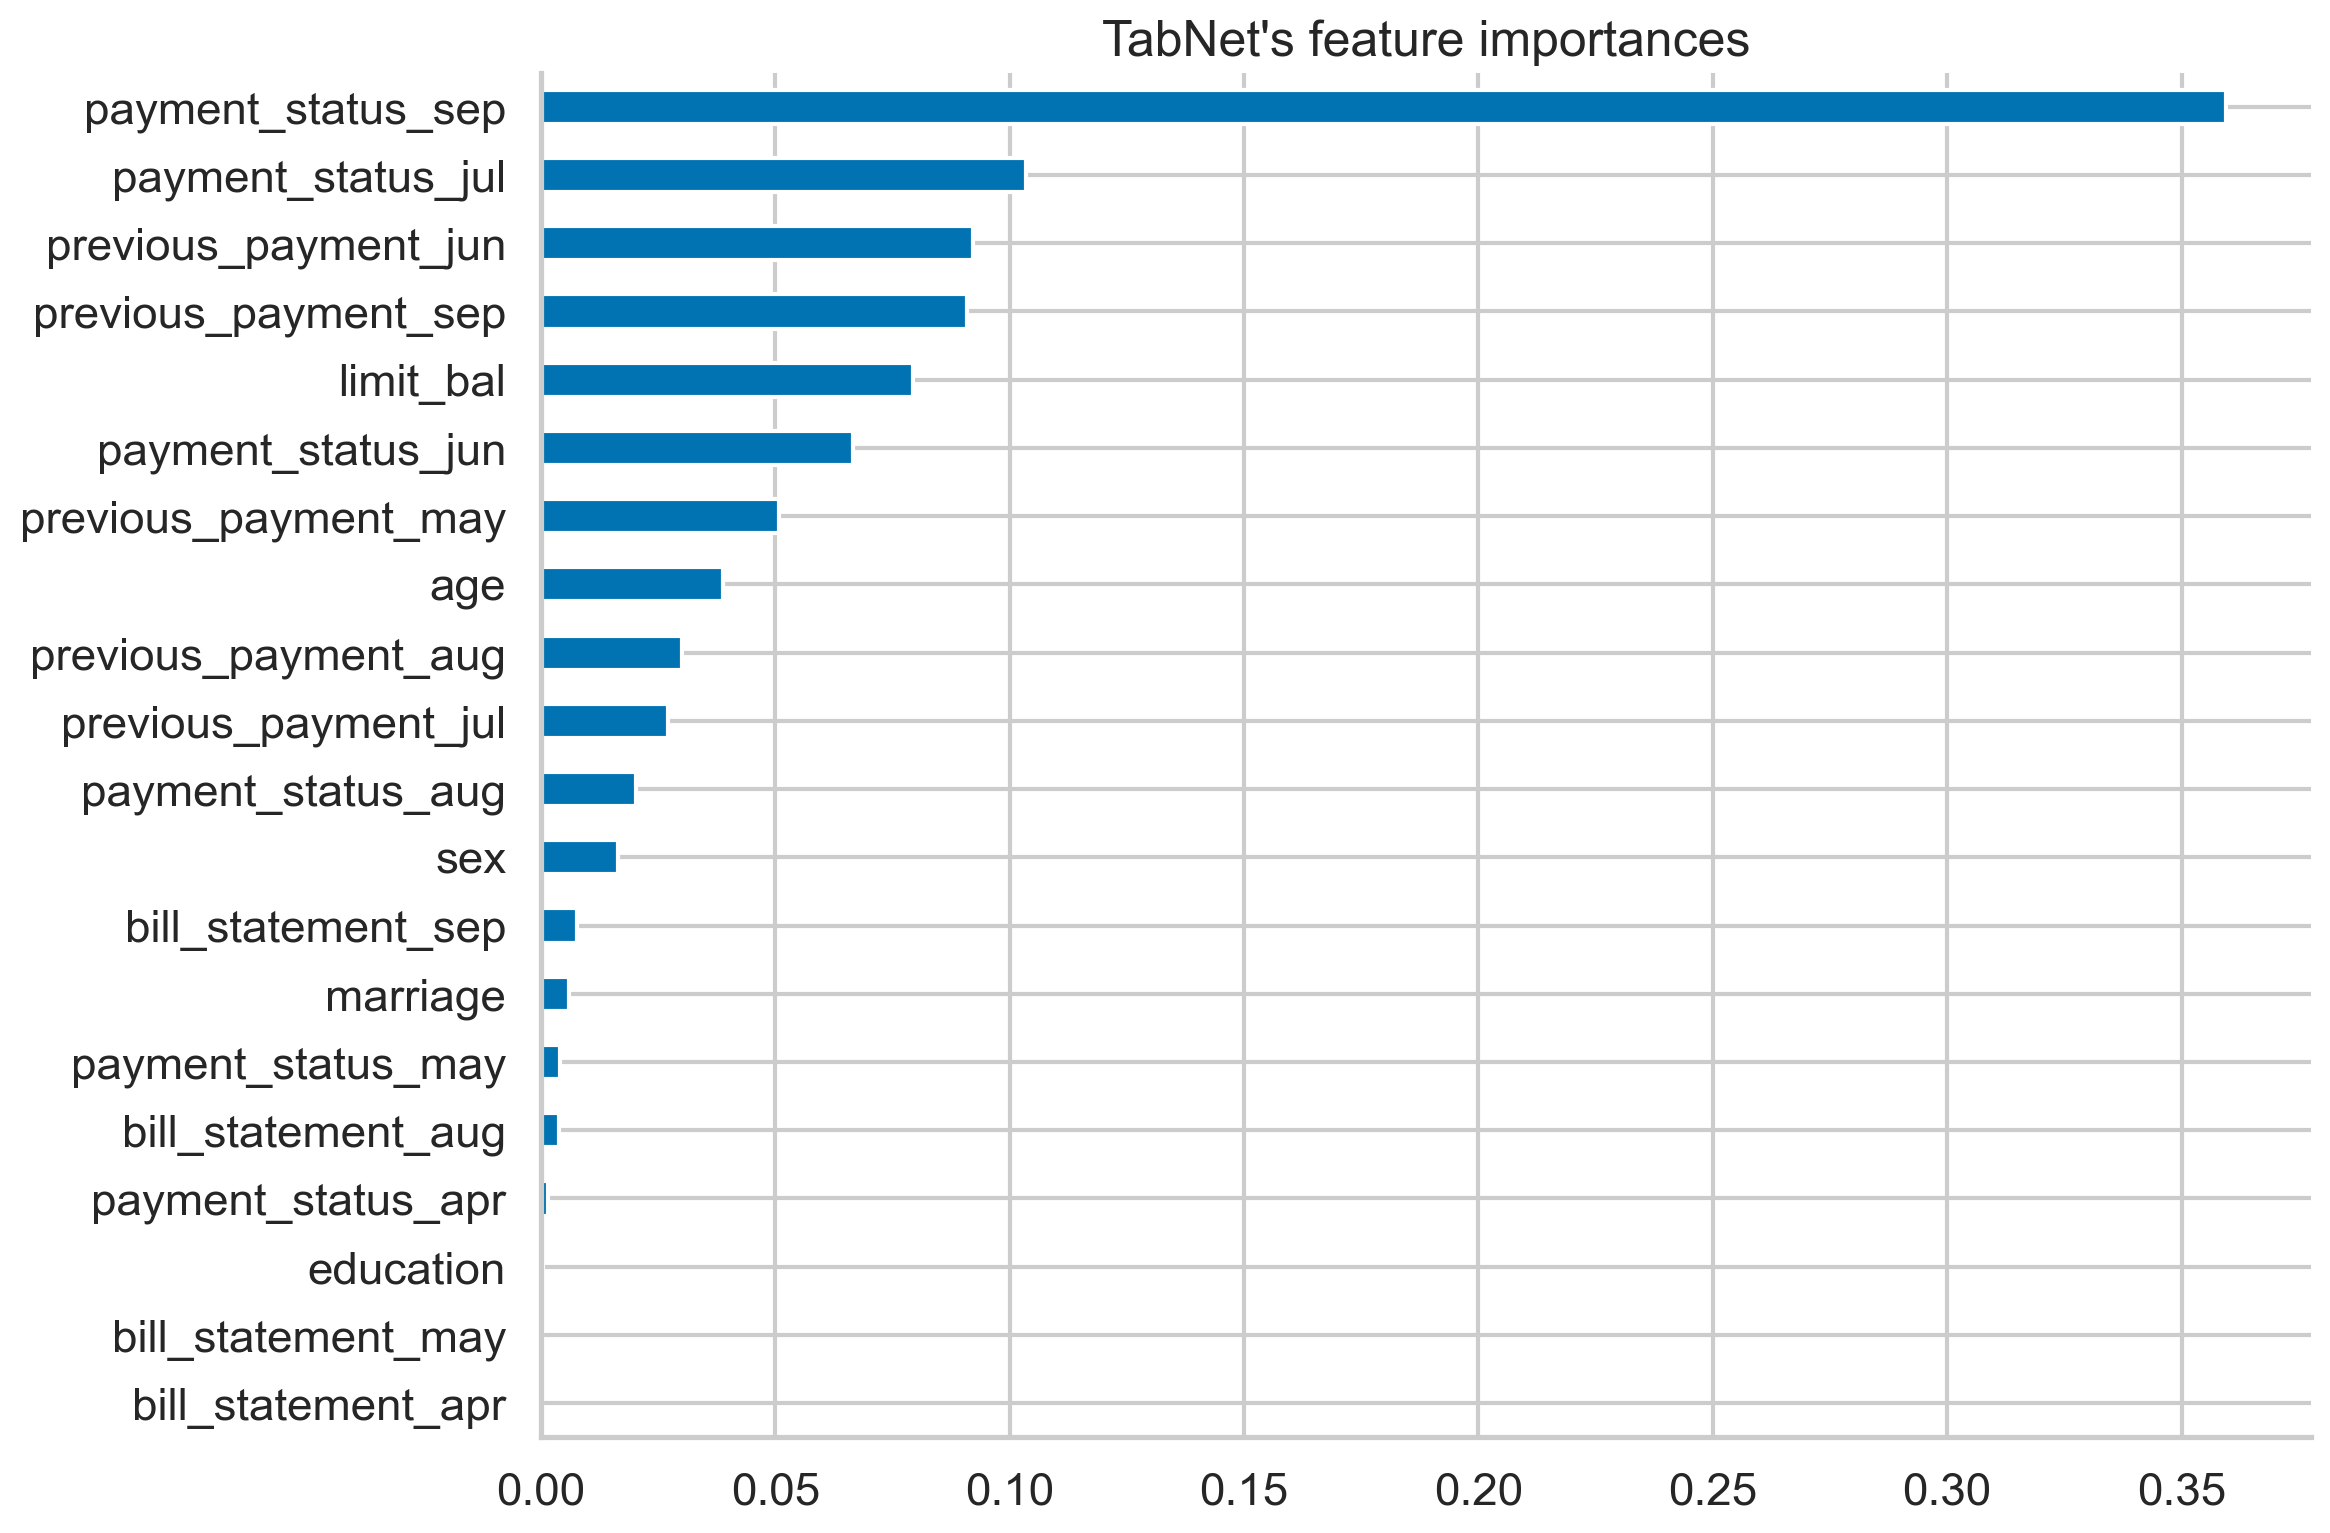

In [50]:
tabnet_feat_imp = pd.Series(tabnet.feature_importances_, index=X_train.columns)
(
    tabnet_feat_imp
    .nlargest(20)
    .sort_values()
    .plot(kind="barh",
          title="TabNet's feature importances")
)

plt.tight_layout()
sns.despine()

In [51]:
np.sum(tabnet.feature_importances_)

0.9999999999999999

## There's more

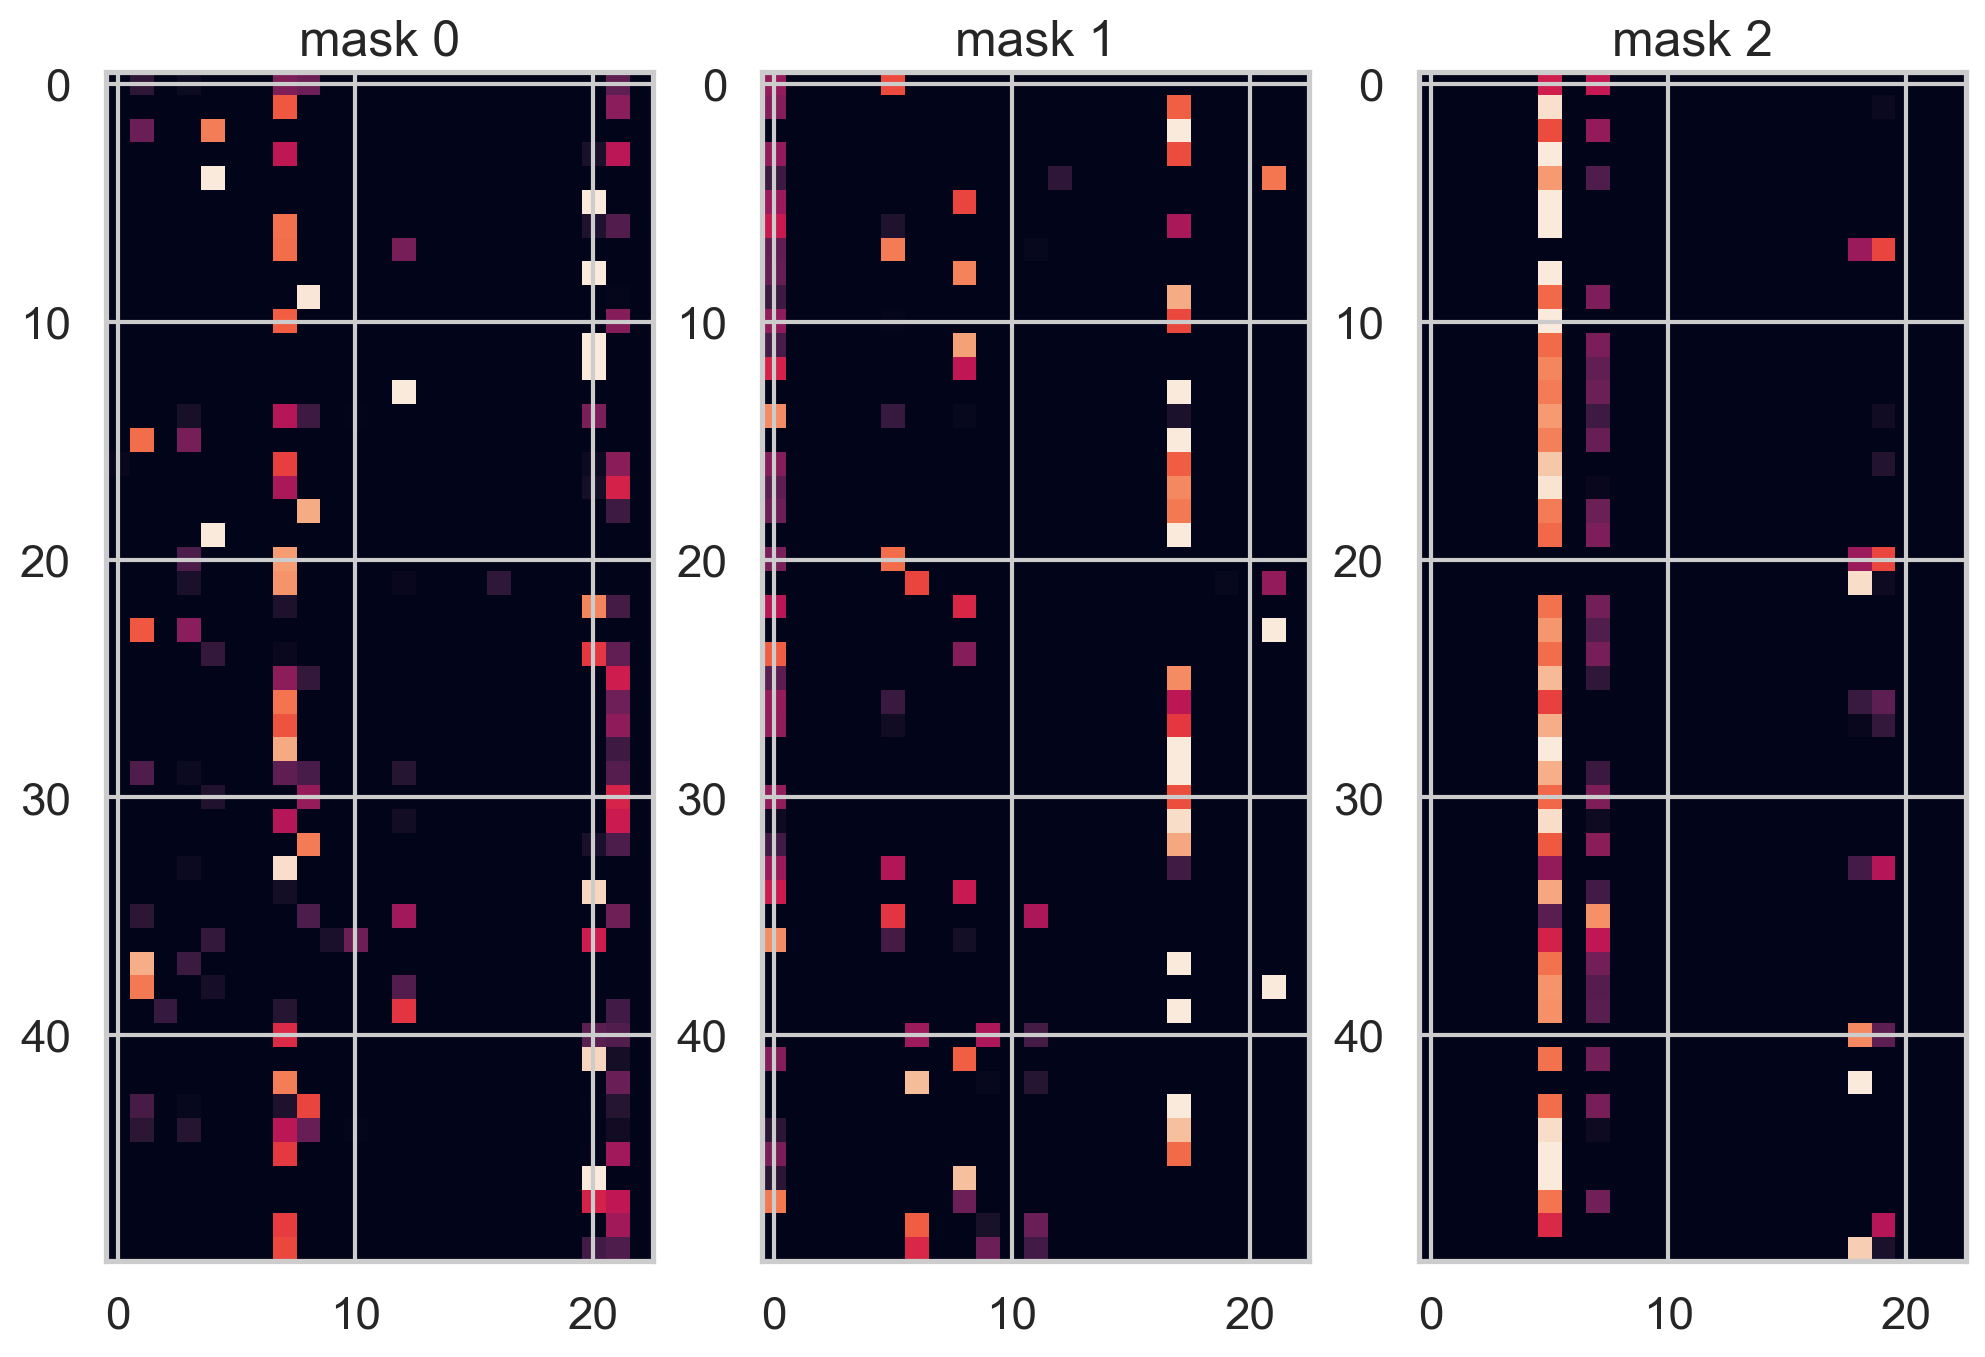

In [52]:
explain_matrix, masks = tabnet.explain(X_test.values)

fig, axs = plt.subplots(1, 3)

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [53]:
explain_matrix.shape

(4500, 23)

In [54]:
X_test.shape

(4500, 23)

In [55]:
# save tabnet model
MODEL_PATH = "./models/tabnet_model"
saved_filepath = tabnet.save_model(MODEL_PATH)

# define new model with basic parameters and load state dict weights
loaded_tabnet = TabNetClassifier()
loaded_tabnet.load_model(saved_filepath)

Successfully saved model at ./models/tabnet_model.zip


/Users/woojin/miniforge3/envs/faitai/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Time series forecasting with Amazon's DeepAR

## How to do it

### 1. Import the libraries

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import yfinance as yf
from random import sample, seed

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import DeepAR, TimeSeriesDataSet

### 2. Download the tickers of the SP500 constituent and sample 100 random tickers from the list

In [58]:
df = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
)
df = df[0]

seed(44)
sampled_tickers = sample(df["Symbol"].to_list(), 100)

### 3. Download the historical stock prices of the selected stocks

In [59]:
raw_df = yf.download(sampled_tickers,
                     start="2020-01-01",
                     end="2021-12-31")

[*********************100%%**********************]  100 of 100 completed


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2021-12-31)')


### 4. Keep the adjusted close price and remove the stocks with missing values

In [60]:
df = raw_df["Adj Close"]
df = df.loc[:, ~df.isna().any()]
selected_tickers = df.columns
df.head()

,ACN,ADBE,AJG,AKAM,ALLE,AME,AMP,AMZN,ANET,ARE,...,T,TEL,TGT,VRSN,WAB,WBD,WDC,WELL,WTW,XYL
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00,199.225403,334.429993,91.043457,87.639999,120.081543,98.410004,157.328400,94.900497,51.180000,144.254547,...,21.716465,90.476074,116.828621,196.729996,79.015549,32.220001,64.771545,70.194054,194.497040,76.566856
2020-01-03 00:00:00,198.893600,331.809998,90.852798,87.239998,118.597153,98.546669,155.366806,93.748497,50.212502,145.076385,...,21.828232,89.407349,115.614662,200.880005,78.410393,32.029999,63.774597,71.429047,194.544647,77.017517
2020-01-06 00:00:00,197.594788,333.709991,91.272240,87.550003,118.376892,98.654053,155.878082,95.143997,50.715000,145.428604,...,21.850588,88.788612,114.521156,202.740005,78.088272,31.959999,62.550629,72.515160,194.782700,76.518913
2020-01-07 00:00:00,193.328720,333.390015,90.290398,90.199997,116.959534,99.220299,154.000153,95.343002,51.212502,140.669159,...,21.934416,90.626068,114.725029,203.210007,78.058998,32.070000,66.785164,72.042175,194.382797,76.231255
2020-01-08 00:00:00,193.707947,337.869995,90.414322,91.400002,117.457535,99.444855,155.385391,94.598503,51.744999,142.538635,...,22.001472,91.563545,114.354355,204.149994,76.721725,32.110001,67.752487,72.059692,194.601761,76.490128


### 5. Convert the data’s format from wide to long and add the time index

In [61]:
df = df.reset_index(drop=False)
df = (
    pd.melt(df,
            id_vars=["Date"],
            value_vars=selected_tickers,
            value_name="price")
            .rename(columns={"variable": "ticker"})
)
df["time_idx"] = df.groupby("ticker").cumcount()

In [62]:
df

,Date,ticker,price,time_idx
0,2020-01-02,ACN,199.225403,0
1,2020-01-03,ACN,198.893600,1
2,2020-01-06,ACN,197.594788,2
3,2020-01-07,ACN,193.328720,3
4,2020-01-08,ACN,193.707947,4
...,...,...,...,...
49387,2021-12-23,XYL,115.248421,499
49388,2021-12-27,XYL,116.023277,500
49389,2021-12-28,XYL,117.229721,501
49390,2021-12-29,XYL,117.072777,502


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49392 entries, 0 to 49391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      49392 non-null  datetime64[ns]
 1   ticker    49392 non-null  object        
 2   price     49392 non-null  float64       
 3   time_idx  49392 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


### 6. Define constants used for setting up the model’s training

In [64]:
MAX_ENCODER_LENGTH = 40
MAX_PRED_LENGTH = 20
BATCH_SIZE = 128
MAX_EPOCHS = 30
training_cutoff = df["time_idx"].max() - MAX_PRED_LENGTH

### 7. Define the training and validation datasets

In [65]:
# train_set = TimeSeriesDataSet(
#     df[lambda x: x["time_idx"] <= training_cutoff],
#     time_idx="time_idx",
#     target="price",
#     group_ids=["ticker"],
#     time_varying_unknown_reals=["price"],
#     max_encoder_length=MAX_ENCODER_LENGTH,
#     max_prediction_length=MAX_PRED_LENGTH,
# )

# valid_set = TimeSeriesDataSet.from_dataset(
#     train_set, df, min_prediction_idx=training_cutoff+1
# )

### 8. Get the DataLoaders from the datasets

In [66]:
# train_dataloader = train_set.to_dataloader(
#     train=True, batch_size=BATCH_SIZE
# )
# valid_dataloader = valid_set.to_dataloader(
#     train=False, batch_size=BATCH_SIZE
# )

### 9. Define the DeepAR model and find the suggested learning rate

In [67]:
# pl.seed_everything(42)

# deep_ar = DeepAR.from_dataset(
#     train_set,
#     learning_rate=1e-2,
#     hidden_size=30,
#     rnn_layers=4
# )

# trainer = pl.Trainer(gradient_clip_val=1e-1)
# res = trainer.tuner.lr_find(
#     deep_ar,
#     train_dataloaders=train_dataloader,
#     valid_dataloaders=valid_dataloader,
#     min_lr=1e-5,
#     max_lr=1e0,
#     early_stop_threshold=100
# )

# print(f"Suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)

# plt.tight_layout()
# sns.despine()

### 10. Train the DeepAR model

In [68]:
# pl.seed_everything(42)

# deep_ar.hparams.learning_rate = res.suggestion()

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-4,
#     patience=10
# )

# trainer = pl.Trainer(
#     max_epochs=MAX_EPOCHS,
#     gradient_clip_val=0.1,
#     callbacks=[early_stop_callback]
# )

# trainer.fit(
#     deep_ar,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=valid_dataloader,
# )

### 11. Extract the best DeepAR model from a checkpoint

In [69]:
# best_model = DeepAR.load_from_checkpoint(
#     trainer.checkpoint_callback.best_model_path
# )

### 12.Create the predictions for the validation set and plot 5 of them

In [70]:
# raw_predictions, x = best_model.predict(
#     valid_dataloader,
#     mode="raw",
#     return_x=True,
#     n_samples=100
# )

# tickers = valid_set.x_to_index(x)["ticker"]

# for idx in range(5):
#     best_model.plot_prediction(
#         x, raw_predictions, idx=idx, add_loss_to_title=True
#     )
#     plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

#     plt.tight_layout()
#     sns.despine()

## There's more

### 1. Import the libraries 

In [71]:
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss
import seaborn as sns
import numpy as np

### 2. Define the DataLoaders again, this time specifying the batch_sampler

In [72]:
# train_set = TimeSeriesDataSet(
#     df[lambda x: x["time_idx"] <= training_cutoff],
#     time_idx="time_idx",
#     target="price",
#     group_ids=["ticker"],
#     static_categoricals=["ticker"],
#     time_varying_unknown_reals=["price"],
#     max_encoder_length=MAX_ENCODER_LENGTH,
#     max_prediction_length=MAX_PRED_LENGTH
# )

# valid_set = TimeSeriesDataSet.from_dataset(
#     train_set, df, min_prediction_idx=training_cutoff+1
# )

# train_dataloader = train_set.to_dataloader(
#     train=True,
#     batch_size=BATCH_SIZE,
#     batch_sampler="synchronized"
# )

# valid_dataloader = valid_set.to_dataloader(
#     train=False,
#     batch_size=BATCH_SIZE,
#     batch_sampler="synchromized"
# )

### 3. Define the DeepVAR model and find the learning rate

In [73]:
# pl.seed_everything(42)

# deep_var = DeepAR.from_dataset(
#     train_set,
#     learning_rate = 1e-2,
#     hidden_size = 30,
#     rnn_layers = 4,
#     loss = MultivariateNormalDistributionLoss()
# )

# trainer = pl.Trainer(gradient_clip_val=1e-1)
# res = trainer.tuner.lr_find(
#     deep_var,
#     train_dataloaders=train_dataloader,
#     val_dataloders=valid_dataloader,
#     min_lr=1e-5,
#     max_lr=1e0,
#     early_stop_threshold=100
# )

# print(f"Suggested learning rate : {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)

### 4. Train the DeepVAR model using the selected learning rate

In [74]:
# pl.seed_everything(42)

# deep_var.hparams.learning_rate = res.suggestion()

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-4,
#     patience=10
# )

# trainer = pl.Trainer(
#     max_epochs=MAX_EPOCHS,
#     gradient_clip_val=0.1,
#     callbacks=[early_stop_callback]
# )

# trainer.fit(
#     deep_var,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=valid_dataloader
# )

### 5. Extract the best DepVAR model from a checkpoint

In [75]:
# best_model = DeepAR.load_from_checkpoint(
#     trainer.checkpoint_callback.best_model_path
# )

### 6. Create the predictions for the validation set and plot 5 of them

In [76]:
# raw_predictions, x = best_model.predict(
#     valid_dataloader,
#     mode="raw",
#     return_x=True,
#     n_samples=100
# )

# tickers = valid_set.x_to_index(x)["ticker"]

# for idx in range(5):
#     best_model.plot_prediction(
#         x, raw_predictions, idx=idx, add_loss_to_title=True
#     )
#     plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

### 7. Extract the correlation matrix

In [77]:
# preds = best_model.predict(valid_dataloader,
#                            mode=("raw", "prediction"),
#                            n_samples=None)

# cov_matrix = (
#     best_model
#     .loss
#     .map_x_to_distribution(preds)
#     .base_dist
#     .covariance_matrix
#     .mean(0)
# )

# # normalize the covariance matrix diagonal to 1.0
# cov_diag_mult = (
#     torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T
# )

# corr_matrix = cov_matrix / torch.sqrt(cov_diag_mult)

### 8. Plot the correlation matrix

In [78]:
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# fif, ax = plt.subplots()

# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(
#     corr_matrix, mask=mask, cmap=cmap,
#     vmax=.3, center=0, square=True,
#     linewidths=.5, cbar_kws={"shrink": .5}
# )

# ax.set_title("Correlation matrix")

# plt.tight_layout()
# sns.despine()

In [79]:
# # distribution of off-diagonal correlations

# plt.hist(corr_matrix[corr_matrix < 1].numpy())

# plt.xlabel("Correlation")
# plt.ylabel("Count")

# plt.tight_layout()
# sns.despine()

# Time series forecasting with NeuralProphet

## How to do it

### 1. Import the libraries

In [1]:
import yfinance as yf
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet.utils import set_random_seed
from nueralprophet.utils import set_log_level

ModuleNotFoundError: No module named 'neuralprophet'

### 2. Download the historical prices of the S&P 500 index and prepare the DataFrame for modeling with NeuralProphet

In [ ]:
df = yf.download("^GSPC",
                 start="2010-01-01",
                 end="2021-12-31")
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["ds", "y"]
df

[*********************100%%**********************]  1 of 1 completed


,ds,y
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015
3,2010-01-07,1141.689941
4,2010-01-08,1144.979980
...,...,...
3015,2021-12-23,4725.790039
3016,2021-12-27,4791.189941
3017,2021-12-28,4786.350098
3018,2021-12-29,4793.060059


### 3. Create the train/test split

In [ ]:
TEST_LENGTH = 60
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

### 4. Train the default Prophet model and plot the evaluation metrics

In [ ]:
from matplotlib.pyplot import xlabel

set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(changepoints_range=0.95)
metrics = model.fit(df_train, freq="B")

(
    metrics
    .drop(columns=["RegLoss"])
    .plot(title="Evaluation metrics during training",
          subplots=True,
          xlabel="epochs",
          ylabel="metric")
)

plt.tight_layout()
sns.despine()

### 5. Calculate the predictions and plot the fit

In [ ]:
pred_df = model.predict(df)

pred_df.plot(x="ds", y=["y", "yhat1"],
             title="S&P 500 - forecast vs ground truth",
             ylabel="value")
plt.tight_layout()
sns.despine()

In [ ]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"],
          title="S&P 500 - forecast vs ground truth",
          yalbel="value")
)

plt.tight_layout()
sns.despine()

In [ ]:
model.test(df_test)

### 6. Add the AR components to NeuralProphet

In [ ]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1
)

metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)
pred_df.plot(x="ds", y=["y", "yhat1"],
             title="S&P 500 - forecast vs ground truth",
             ylabel="value")

plt.tight_layout()
sns.despine()

In [ ]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"],
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
)

plt.tight_layout()
sns.despine()

### 7. Add the AR-Net to NueralProphet

In [ ]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepronts_range=0.95,
    n_lags = 10,
    ar_reg = 1,
    ar_layers = [32, 32, 32],
    # num_hidden_layers = 3,
    # d_hidden = 32
)

metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)

(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"],
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
)

plt.tight_layout()
sns.despine()

In [ ]:
model.test(df_test)

### 8. Plot the components and parameters of the model

In [ ]:
# for plotting only, as there is some issue with the AR plot
# after plotting the components we can revert to the settings at the top of the Notebook
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
model.plot_compoents(model.predict(df_train))

plt.tight_layout()
sns.despine()

In [ ]:
model.plot_parameters()

plt.tight_layout()
sns.despine()

## There's more

### 1. Add holidays to the model

In [ ]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
    ar_layers=[32, 32, 32]
    # num_hidden_layers=3,
    # d_hidden=32
)

model = model.add_country_holidays(
    "US", lower_window=-1, upper_window=1
)

metrics = model.fit(df_train, freq="B")

In [ ]:
pred_df = model.predict(df_train)
model.plot_components(pred_df)

plt.tight_layout()
sns.despine()

In [ ]:
model.plot_parameters()

### 2. Create a 10-day ahead multi-step forecast

In [ ]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    n_lags=10,
    n_forecasts=10,
    ar_reg=1,
    learning_rate=0.01
)
metrics = model.fit(df_train, freq="B")
pred_df = model.predict(df)
pred_df.tail()

In [ ]:
# set_random_seed(42)
pred_df = model.predict(df, raw=True, decompose=False)
pred_df.tail().round(2)

In [ ]:
pred_df = model.predict(df_test)
model.plot(pred_df)
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("10-day ahead multi-step forecast")

plt.tight_layout()
sns.depine()

In [ ]:
model = model.highlight_nth_step_ahead_of_each_forecast()
model.plot(pred_df)
ax = plt.gca()
ax.set_title("Step 1 of the 10-day ahead multi-step forecast")

plt.tight_layout()
sns.despine()